Import Libraries

In [35]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.preprocessing import LabelEncoder


pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 2 # let's look at sample match 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Import Metrics

In [2]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [14]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)
events = mio.to_metric_coordinates(events)

Reading team: home
Reading team: away


Merge the two tracking DataFrames based on the 'Time [s]' column, which is common to both

In [15]:
tracking_data = pd.merge(tracking_away, tracking_home, on='Time [s]', how='outer')

# Sort the combined DataFrame by the 'Time [s]' column
tracking_data = tracking_data.sort_values(by='Time [s]')

# Reset the index of the combined DataFrame
tracking_data.reset_index(drop=True, inplace=True)

# fill NaN values with 0:
tracking_data.fillna(0, inplace=True)
tracking_data.drop(['ball_x_x', 'ball_y_x', 'Period_y'], axis=1, inplace=True)
tracking_data.rename(columns={'ball_x_y': 'ball_x', 'ball_y_y': 'ball_y', 'Period_x': 'Period'}, inplace=True)
tracking_data
tracking_data.to_csv('tracking_data.csv', index=False)

In [16]:
# Save the events dataset
events.to_csv('events.csv', index=False)

Visualize the dataframes

In [17]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,-0.00,-10.60,-0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,-0.00,-6.36,19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,21.08,-20.14,14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,12.24,-25.44,-5.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,4.24,-18.36,-22.26,17.68
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,-20.14,13.60,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,-19.08,13.60,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,-16.96,12.24,NaN,NaN


In [18]:
tracking_data

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,Away_18_x,Away_18_y,Away_19_x,Away_19_y,Away_20_x,Away_20_y,Away_21_x,Away_21_y,Away_22_x,Away_22_y,Away_23_x,Away_23_y,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
0,1,0.04,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
1,1,0.08,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
2,1,0.12,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
3,1,0.16,-51.70892,-1.19884,-18.19384,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.35076,16.40840,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
4,1,0.20,-51.70892,-1.19884,-18.25002,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.43980,16.40772,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141151,2,5646.08,43.68366,1.14852,-1.03032,37.40000,-1.15434,3.54416,10.37528,-5.07824,-7.39138,-7.52964,-10.17388,-2.99676,-25.87036,7.87100,-3.44394,-37.40000,0.00000,0.00000,-24.53370,-8.0546,-14.03440,25.50272,-5.33604,5.73104,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,0.00000,0.00000,-9.97248,28.55864,-11.75010,-4.36084,-14.61104,-4.22824,0.00000,0.00000,-22.86844,9.62540,0.00000,0.00000,-9.71278,24.17468,1.09392,-30.29672,-23.36028,9.04400,0.0,0.0
141152,2,5646.12,43.66246,1.14852,-1.03032,37.40000,-1.17236,3.56252,10.35302,-5.10612,-7.39032,-7.52216,-10.17494,-3.02532,-25.87036,7.87100,-3.40260,-37.40000,0.00000,0.00000,-24.53370,-8.0546,-14.03440,25.50272,-5.31802,5.74600,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,0.00000,0.00000,-9.97248,28.55864,-11.69710,-4.34860,-14.61104,-4

Find Average of the time difference between events

In [20]:
# Convert 'Time' column to datetime format
events['Start Time [s]'] = pd.to_datetime(events['Start Time [s]'])

# Calculate the time differences
events['Start Time [s]'] = events['Start Time [s]'].diff().dt.total_seconds().fillna(0)

# Calculate the average time difference
average_time_diff = events['Start Time [s]'].mean()


In [21]:
average_time_diff

2.8981912144702847e-09

Find Home Team High Pressure moment

In [23]:
# dimensions of the field: 105x68 meters.
home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2))]
home_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [27]:
# Save home high pressure moments
home_moments.to_csv('home_moments.csv', index=False)

In [31]:
# Save home and away players
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

# Loop through each row and calculate the distance for each player
for index, row in home_moments.iterrows():
    distances_away = []
    distances_home = []
    ball_x = row['ball_x']
    ball_y = row['ball_y']

    for a_player in a_players:
        # Get the index of the current player column
        a_index = row.index.get_loc(a_player)
        away_x = row.iloc[a_index]
        away_y = row.iloc[a_index + 1]

        # Calculate Euclidean distance
        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)
        distances_away.append(distance_away)

    for h_player in h_players:
        # Get the index of the current player column
        h_index = row.index.get_loc(h_player)
        home_x = row.iloc[h_index]
        home_y = row.iloc[h_index + 1]

        # Calculate Euclidean distance
        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)
        distances_home.append(distance_home)
    
    away_min_dist = np.min(distances_away)
    home_min_dist = np.min(distance_home)
    # Find the minimum distance for the current row
    if home_min_dist < away_min_dist :
        home_moments.drop(index, inplace=True)

In [29]:
home_moments.shape

(117, 56)

Find the exact event before the high pressure moment happen

In [43]:
home_event = pd.DataFrame(columns=events.columns)

for index, row in home_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)

home_event
#save to csv
home_event.to_csv('home_event.csv', index=False)


In [45]:
# This part is because to easier rerun the code and not run the above for faster analysis on the created dataframes
home_event = pd.read_csv('home_event.csv')
tracking_data = pd.read_csv('tracking_data.csv')
events = pd.read_csv('events.csv')

Visualize Leading Events for Team Home

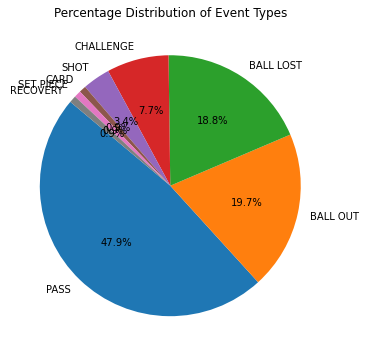

In [46]:
# Pie Chart for percentage distribution of event types
event_type_counts = home_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [47]:
# Imputing missing values with 'Unknown'
home_event['Subtype'].fillna('Unknown', inplace=True)
home_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = home_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Home 

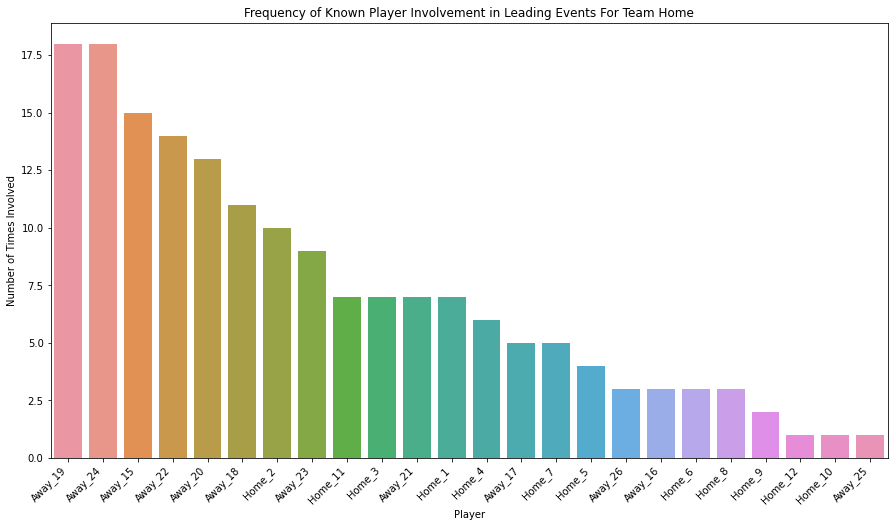

In [48]:
# Combined the two columns of event dataframe to aggregate players
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

Separate Away and Home by its color

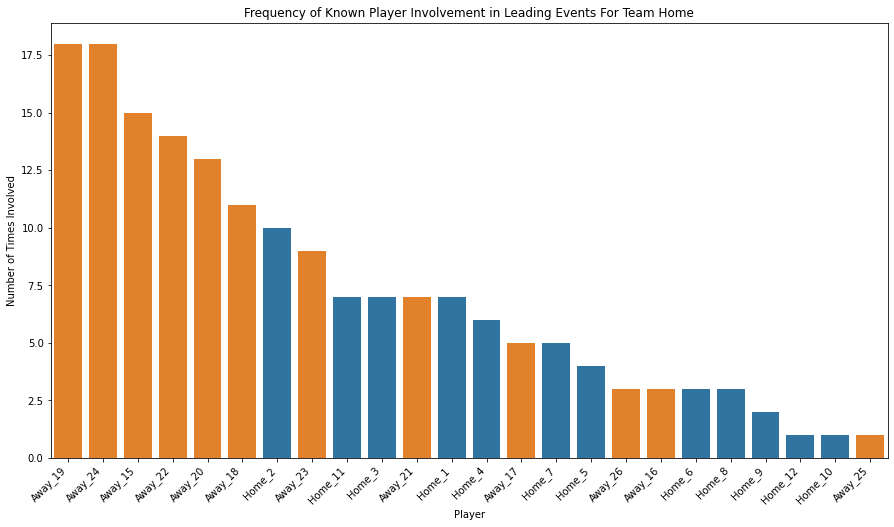

In [49]:
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

###### Hot Encoding

In [53]:
# Selecting the relevant columns for clustering
features = home_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CARD,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-LOST,Subtype_CLEARANCE,Subtype_CROSS,Subtype_GROUND,Subtype_GROUND-FAULT-LOST,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HEAD,Subtype_HEAD-CLEARANCE,Subtype_HEAD-INTERCEPTION,Subtype_INTERCEPTION,Subtype_OFF TARGET-HEAD-OUT,Subtype_OFF TARGET-OUT,Subtype_TACKLE-LOST,Subtype_THROW IN,Subtype_Unknown,Subtype_YELLOW,From_Player 26,From_Player1,From_Player10,From_Player11,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player 26,To_Player1,To_Player11,To_Player12,To_Player15,To_Player18,To_Player19,To_Player2,To_Player20,To_Player22,To_Player23,To_Player24,To_Player3,To_Player7,To_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [54]:
# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
home_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
home_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,23.32,31.28,39.22,25.16,3
1,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,23.32,31.28,39.22,25.16,3
2,Home,PASS,Unknown,1,2511,100.44,2546,101.84,Player4,Player3,11.66,-31.96,27.56,-25.16,2
3,Home,PASS,Unknown,1,3248,129.92,3311,132.44,Player3,Player11,8.48,15.64,38.16,3.40,2
4,Away,PASS,Unknown,1,14189,567.56,14234,569.36,Player15,Player19,12.72,-33.32,26.50,-24.48,4


##### Analysis of clusters

In [55]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = home_event[home_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,CHALLENGE 9 SHOT 4 SET PIECE 1 N...,Player19 2 Player18 2 Player1 2 Name...,"Unknown 15 Name: To, dtype: int64"
1,BALL OUT 23 BALL LOST 5 RECOVERY ...,Player22 4 Player17 4 Player20 3 Name...,"Unknown 29 Name: To, dtype: int64"
2,"PASS 46 Name: Type, dtype: int64",Player20 5 Player15 5 Player4 4 Name...,Player24 10 Player2 6 Player11 6 N...
3,"BALL LOST 17 Name: Type, dtype: int64",Player24 4 Player20 2 Player19 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"PASS 10 Name: Type, dtype: int64",Player15 4 Player21 2 Player22 2 Name...,"Player19 10 Name: To, dtype: int64"


In [59]:
# Better Visualization and save the output

# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
home_event['Cluster'] = clusters

# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = home_event[home_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = ', '.join(cluster_data['Type'].value_counts().head(3).index)
    
    # Most common 'From' players in this cluster
    common_from_players = ', '.join(cluster_data['From'].value_counts().head(3).index)
    
    # Most common 'To' players in this cluster
    common_to_players = ', '.join(cluster_data['To'].value_counts().head(3).index)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster in a table
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df
# Save the DataFrame to a CSV file
cluster_analysis_df.to_csv('cluster_analysis_output.csv')

##### Visualize clusters

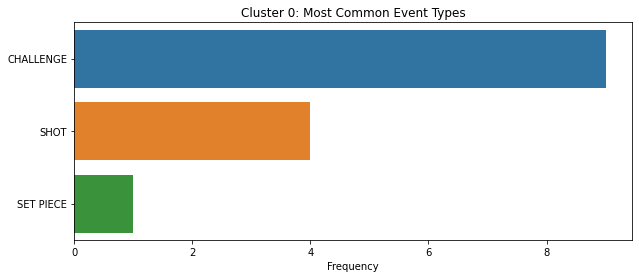

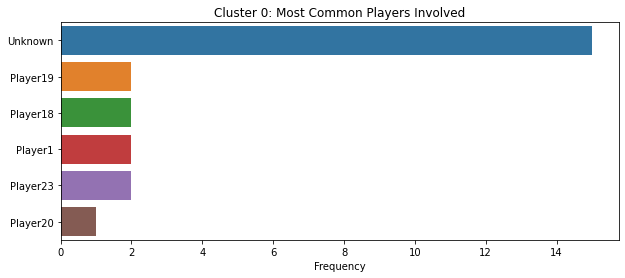

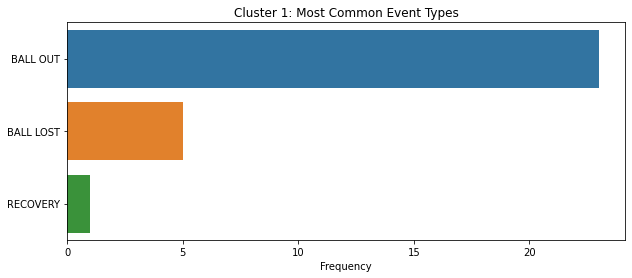

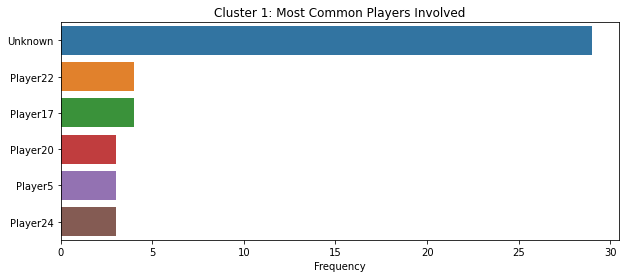

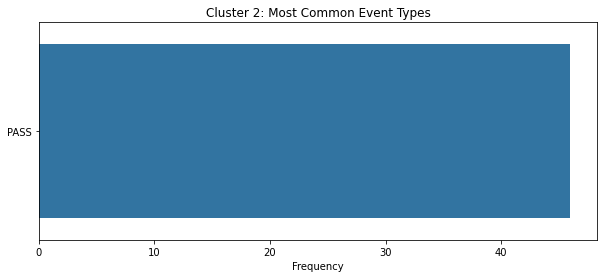

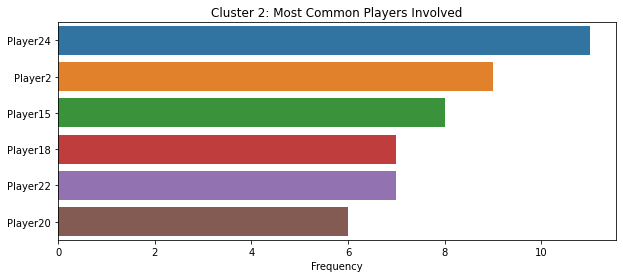

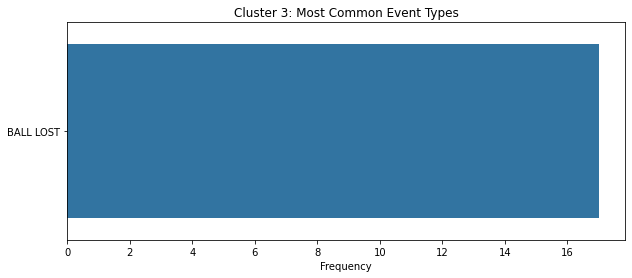

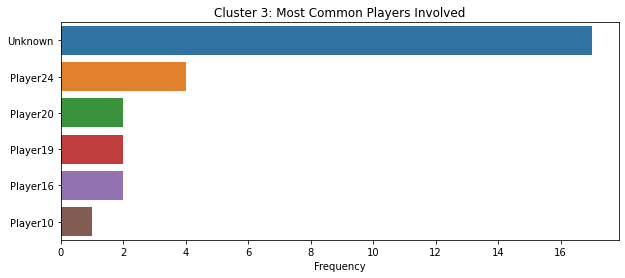

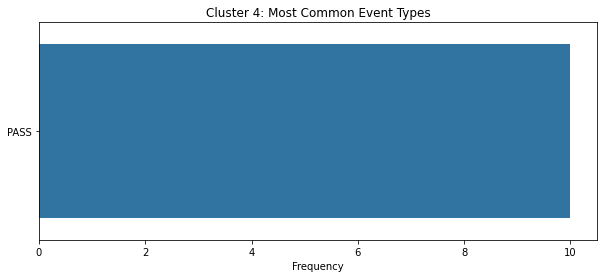

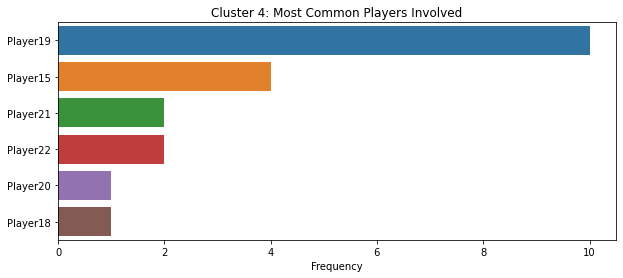

In [60]:
def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Find Away Team High Pressure moment

In [61]:
away_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1))]
away_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [64]:
# Save away high pressure moments
away_moments.to_csv('away_moments.csv', index=False)

Find the exact event before the high pressure moment happen

In [65]:
away_event = pd.DataFrame(columns=events.columns)

for index, row in away_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            away_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= away_time and previous_start_time < away_time:
                away_event = away_event.append(events.iloc[e_index - 1], ignore_index=True)

away_event
away_event.to_csv('away_event.csv', index=False)

Visualize Leading Events for Team Away

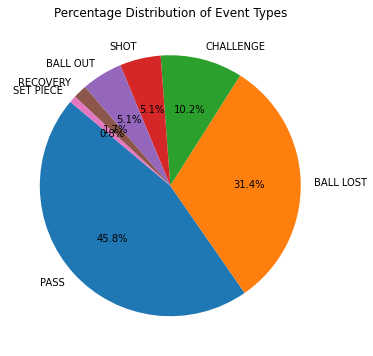

In [ ]:
# Pie Chart for percentage distribution of event types
event_type_counts = away_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [66]:
# Imputing missing values with 'Unknown'
away_event['Subtype'].fillna('Unknown', inplace=True)
away_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = away_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Away 

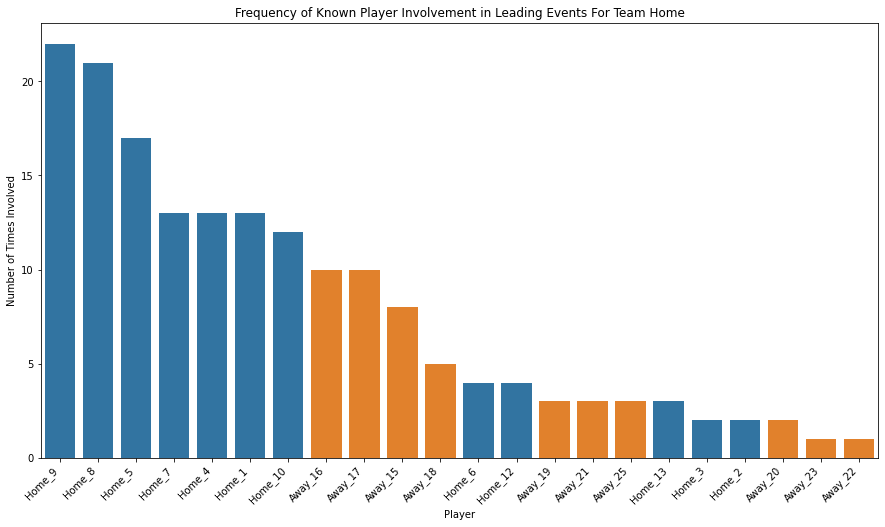

In [67]:
combined_players = away_event['From'].append(away_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [68]:
# Selecting the relevant columns for clustering
features = away_event[['Type', 'Subtype', 'From', 'To']]
# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)
# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))
# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-FAULT-LOST,Subtype_AERIAL-LOST,Subtype_CROSS-INTERCEPTION,Subtype_DEEP BALL,Subtype_FORCED,Subtype_FREE KICK,Subtype_GROUND-FAULT-WON,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HAND BALL,Subtype_HEAD-INTERCEPTION,Subtype_HEAD-OFF TARGET-OUT,Subtype_INTERCEPTION,Subtype_OFF TARGET-OUT,Subtype_OFFSIDE,Subtype_ON TARGET-SAVED,Subtype_TACKLE-LOST,Subtype_THEFT,Subtype_Unknown,From_Player1,From_Player10,From_Player12,From_Player13,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player1,To_Player10,To_Player12,To_Player16,To_Player17,To_Player19,To_Player20,To_Player21,To_Player25,To_Player5,To_Player7,To_Player8,To_Player9,To_Unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [69]:
# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)
# Adding the cluster labels to the original dataframe
away_event['Cluster'] = clusters
# Displaying a few rows of the dataframe with cluster labels
away_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,PASS,Unknown,1,768,30.72,808,32.32,Player16,Player17,-22.26,-23.12,-28.62,-2.04,0
1,Away,PASS,Unknown,1,956,38.24,1016,40.64,Player15,Player16,-23.32,-33.32,-37.10,-27.20,0
2,Home,BALL LOST,INTERCEPTION,1,2997,119.88,3037,121.48,Player1,Unknown,-16.96,31.28,-32.86,14.28,1
3,Home,PASS,Unknown,1,3828,153.12,3875,155.00,Player8,Player7,-23.32,-29.92,-37.10,-29.24,0
4,Home,PASS,Unknown,1,4132,165.28,4177,167.08,Player5,Player1,-20.14,-3.40,-30.74,29.24,0


##### Analysis of clusters

In [70]:
# Analyzing each cluster
cluster_analysis = []
for cluster_num in range(5):
    cluster_data = away_event[away_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })
# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,"PASS 54 Name: Type, dtype: int64",Player5 8 Player4 6 Player15 6 Name...,Player8 11 Player1 8 Player9 7 Name...
1,BALL LOST 27 SET PIECE 1 RECOVERY ...,Player5 6 Player9 5 Player8 4 Name: F...,"Unknown 29 Name: To, dtype: int64"
2,"CHALLENGE 12 Name: Type, dtype: int64",Player10 3 Player16 2 Player18 1 Name...,"Unknown 12 Name: To, dtype: int64"
3,BALL LOST 10 BALL OUT 6 RECOVERY ...,Player10 2 Player4 2 Player1 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"SHOT 6 Name: Type, dtype: int64",Player9 3 Player4 1 Player5 1 Name: F...,"Unknown 6 Name: To, dtype: int64"


##### Visualize clusters

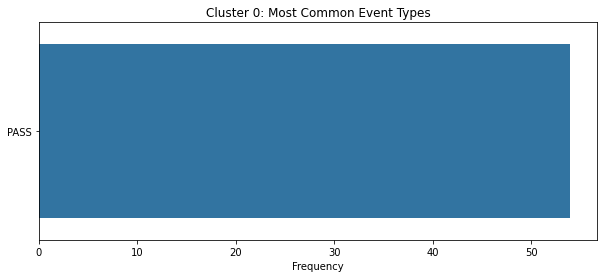

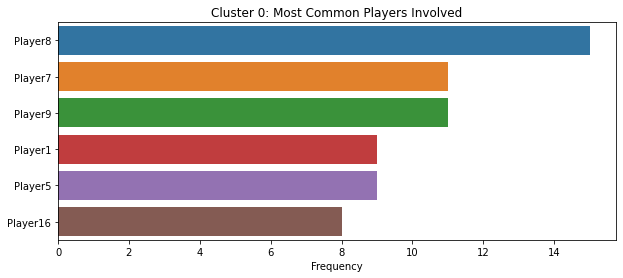

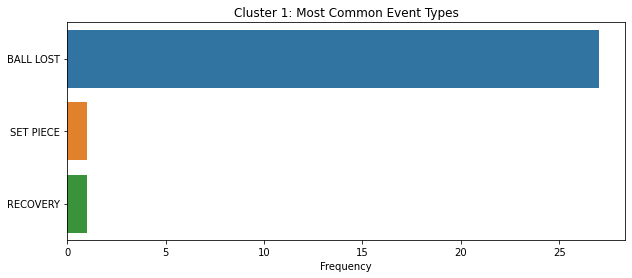

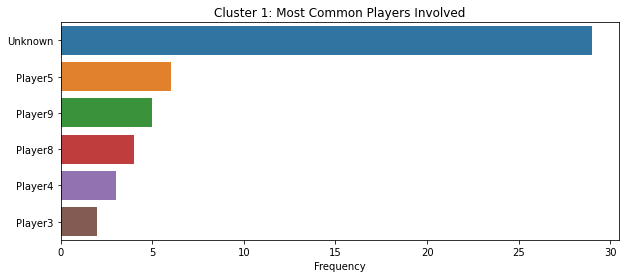

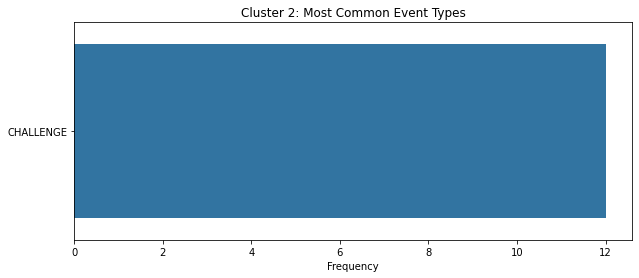

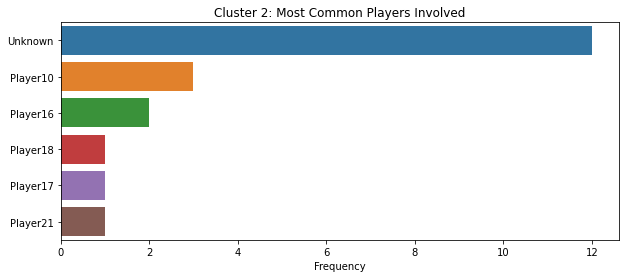

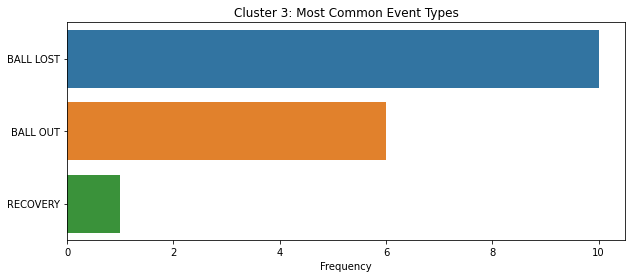

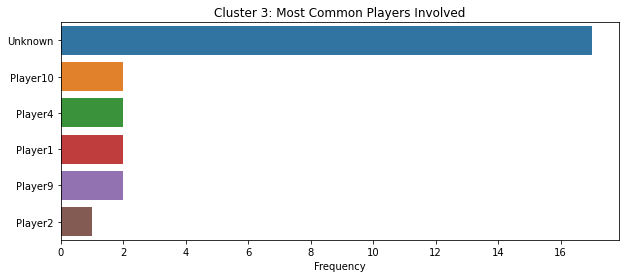

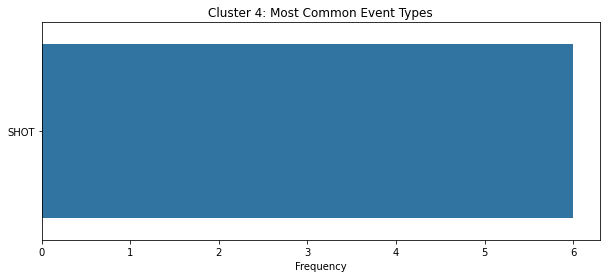

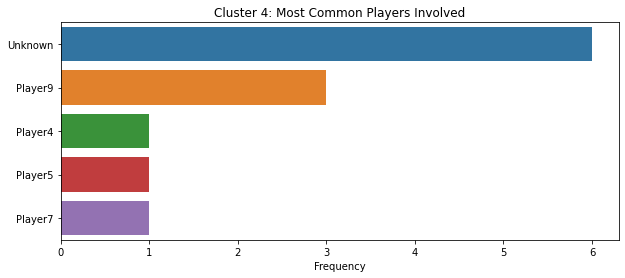

In [71]:
def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = away_event[away_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Find up to three events leading up to each moment within a specified time window (15 s)

In [72]:
def find_leading_events(moment_df, events_df, time_window):
    leading_events = []

    for _, moment in moment_df.iterrows():
        period = moment['Period']
        moment_time = moment['Time [s]']
        # Filtering events that are in the same period and within the time window
        valid_events = events_df[
            (events_df['Period'] == period) &
            (events_df['Start Time [s]'] <= moment_time) &
            (events_df['Start Time [s]'] >= moment_time - time_window)
        ]
        # Sort by time descending (most recent first) and take up to 3 events
        valid_events = valid_events.sort_values(by='Start Time [s]', ascending=False).head(3)
        
        # Add moment identifier columns to each valid event
        valid_events['Moment Period'] = period
        valid_events['Moment Time [s]'] = moment_time

        leading_events.append(valid_events)

    return pd.concat(leading_events, ignore_index=True)

# Define the time window (15 seconds)
time_window = 15

# Find leading events for home moments
leading_events_home = find_leading_events(home_moments, events, time_window)

leading_events_home.to_csv("leading_events_home.csv")

In [73]:
leading_events_home

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,23.32,31.28,39.22,25.16,1.0,55.96
1,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,-1.06,21.76,12.72,21.76,1.0,55.96
2,Away,PASS,NaN,1,1170,46.80,1224,48.96,Player20,Player18,-14.84,-10.20,-14.84,17.68,1.0,55.96
3,Home,RECOVERY,INTERCEPTION,1,1431,57.24,1431,57.24,Player1,NaN,39.22,25.16,NaN,NaN,1.0,57.24
4,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,23.32,31.28,39.22,25.16,1.0,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,Away,PASS,NaN,2,135929,5437.16,135985,5439.40,Player21,Player23,-21.20,-18.36,-39.22,-25.84,2.0,5437.80
323,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,2,135910,5436.40,135910,5436.40,Player21,NaN,-21.20,-17.00,NaN,NaN,2.0,5437.80
324,Away,PASS,NaN,2,135876,5435.04,135894,5435.76,Player19,Player21,-18.02,-25.16,-22.26,-17.00,2.0,5437.80
325,Home,RECOVERY,NaN,2,136961,5478.44,136961,5478.44,Player11,NaN,-46.64,-6.12,NaN,NaN,2.0,5478.44


In [74]:
# Find leading events for away moments
leading_events_away = find_leading_events(away_moments, events, time_window)

leading_events_away

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,PASS,NaN,1,768,30.72,808,32.32,Player16,Player17,-22.26,-23.12,-28.62,-2.04,1.0,31.68
1,Away,SET PIECE,THROW IN,1,672,26.88,672,26.88,Player15,NaN,NaN,NaN,NaN,NaN,1.0,31.68
2,Away,PASS,NaN,1,672,26.88,722,28.88,Player15,Player16,0.00,-34.68,-18.02,-28.56,1.0,31.68
3,Away,PASS,NaN,1,956,38.24,1016,40.64,Player15,Player16,-23.32,-33.32,-37.10,-27.20,1.0,38.72
4,Away,PASS,NaN,1,925,37.00,947,37.88,Player16,Player15,-28.62,-25.16,-23.32,-33.32,1.0,38.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,Away,PASS,NaN,2,134356,5374.24,134383,5375.32,Player15,Player16,19.08,23.80,26.50,14.28,2.0,5375.28
330,Away,PASS,NaN,2,134310,5372.40,134340,5373.60,Player23,Player15,8.48,23.12,19.08,23.12,2.0,5375.28
331,Away,PASS,NaN,2,134290,5371.60,134310,5372.40,Player20,Player23,10.60,11.56,8.48,23.12,2.0,5375.28
332,Home,SET PIECE,FREE KICK,2,139891,5595.64,139891,5595.64,Player9,NaN,NaN,NaN,NaN,NaN,2.0,5595.92


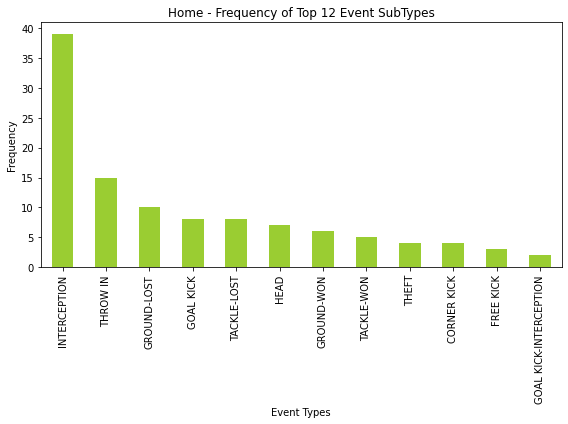

In [76]:
# Calculate the event counts
event_counts = leading_events_home['Subtype'].value_counts()
# Select the top 12 event types
top_12_events = event_counts.head(12)
# Plotting the bar chart for the top 12 events
plt.figure(figsize=(8, 6))
top_12_events.plot(kind='bar', color='yellowgreen')
plt.title('Home - Frequency of Top 12 Event SubTypes')
plt.xlabel('Event Types')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

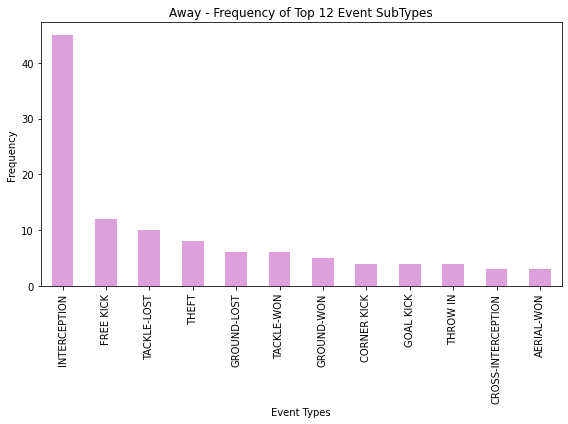

In [77]:
# Calculate the event counts
event_counts = leading_events_away['Subtype'].value_counts()
# Select the top 12 event types
top_12_events = event_counts.head(12)
# Plotting the bar chart for the top 12 events
plt.figure(figsize=(8, 6))
top_12_events.plot(kind='bar', color='plum')
plt.title('Away - Frequency of Top 12 Event SubTypes')
plt.xlabel('Event Types')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

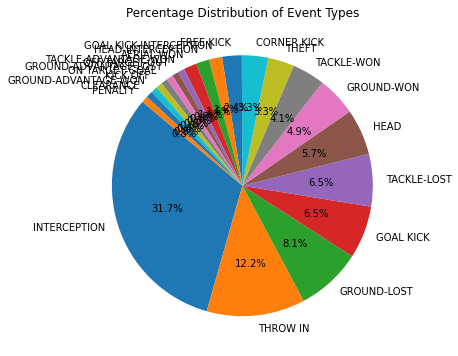

In [78]:
# Pie Chart for percentage distribution of event types for Home
event_type_counts = leading_events_home['Subtype'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

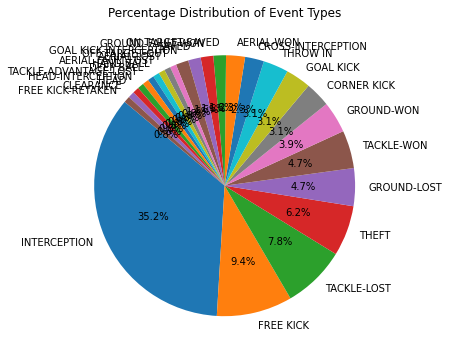

In [79]:
# Pie Chart for percentage distribution of event types for Away
event_type_counts = leading_events_away['Subtype'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Create triples of leading events

In [88]:
def create_event_triples(triple_leading_events):

    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        events = group.to_dict('records')
        triple = [events[i] if i < len(events) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['Event 1', 'Event 2', 'Event 3'])

# Create event triples for home and away
triples_home = create_event_triples(leading_events_home)
triples_away = create_event_triples(leading_events_away)

triples_home.head(), triples_away.head()
triples_home.drop([])

,Event 1,Event 2,Event 3
0,"{'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
1,"{'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...","{'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
2,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'..."
3,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...","{'Team': 'Away', 'Type': 'BALL LOST', 'Subtype..."
4,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
...,...,...,...
112,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
113,"{'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...","{'Team': 'Away', 'Type': 'RECOVERY', 'Subtype'...","{'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'..."
114,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
115,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'CHALLENGE', 'Subtype...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."


In [80]:
# Re-define the create_event_triples function to include only the 'Type' of each event
def create_event_type_triples(triple_leading_events):
    """
    Create triples of event types for each moment.

    :param triple_leading_events: DataFrame containing leading events for each moment.
    :return: DataFrame with triples of event types for each moment.
    """
    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        event_types = group['Type'].tolist()
        triple = [event_types[i] if i < len(event_types) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['1 Event Before', '2 Events Before', '3 Events Before'])

# Create event type triples for home and away
type_triples_home = create_event_type_triples(leading_events_home)
type_triples_away = create_event_type_triples(leading_events_away)

type_triples_home.head(), type_triples_away.head()


(  1 Event Before 2 Events Before 3 Events Before
 0      BALL LOST            PASS            PASS
 1       RECOVERY       BALL LOST            PASS
 2           PASS            PASS        RECOVERY
 3           PASS        RECOVERY       BALL LOST
 4           PASS            PASS            PASS,
   1 Event Before 2 Events Before 3 Events Before
 0           PASS       SET PIECE            PASS
 1           PASS            PASS            PASS
 2      BALL LOST            PASS            PASS
 3           PASS            PASS            PASS
 4           PASS            PASS            PASS)

In [81]:
type_triples_home.to_csv("type_triples_home.csv")

In [82]:
type_triples_away.to_csv("type_triples_away.csv")

In [83]:
# Frequency analysis for each event position in both datasets
freq_home_1 = type_triples_home['1 Event Before'].value_counts()
freq_home_2 = type_triples_home['2 Events Before'].value_counts()
freq_home_3 = type_triples_home['3 Events Before'].value_counts()

freq_away_1 = type_triples_away['1 Event Before'].value_counts()
freq_away_2 = type_triples_away['2 Events Before'].value_counts()
freq_away_3 = type_triples_away['3 Events Before'].value_counts()

(freq_home_1, freq_home_2, freq_home_3, freq_away_1, freq_away_2, freq_away_3)

(PASS         53
 RECOVERY     25
 SET PIECE    18
 BALL LOST     9
 CHALLENGE     6
 BALL OUT      6
 Name: 1 Event Before, dtype: int64,
 PASS         78
 CHALLENGE    12
 RECOVERY     11
 BALL LOST    10
 SET PIECE     3
 SHOT          2
 BALL OUT      1
 Name: 2 Events Before, dtype: int64,
 PASS              50
 CHALLENGE         16
 BALL LOST         12
 RECOVERY           8
 BALL OUT           3
 SET PIECE          3
 FAULT RECEIVED     1
 Name: 3 Events Before, dtype: int64,
 PASS         52
 RECOVERY     29
 SET PIECE    15
 CHALLENGE    11
 BALL LOST    11
 Name: 1 Event Before, dtype: int64,
 PASS         64
 BALL LOST    22
 RECOVERY     16
 CHALLENGE    10
 SET PIECE     3
 SHOT          2
 Name: 2 Events Before, dtype: int64,
 PASS              56
 CHALLENGE         14
 BALL LOST         14
 RECOVERY           7
 BALL OUT           3
 SET PIECE          3
 SHOT               1
 FAULT RECEIVED     1
 Name: 3 Events Before, dtype: int64)

In [84]:
# Function to count sequences
def count_sequences(df):
    sequences = df.apply(lambda row: tuple(row.dropna().values), axis=1)
    return Counter(sequences)

# Counting sequences for home and away datasets
sequence_counts_home = count_sequences(type_triples_home.iloc[:, 1:])
sequence_counts_away = count_sequences(type_triples_away.iloc[:, 1:])

# Displaying the most common sequences
most_common_home = sequence_counts_home.most_common(5)
most_common_away = sequence_counts_away.most_common(5)

most_common_home, most_common_away

([(('PASS', 'PASS'), 37),
  (('PASS',), 16),
  (('PASS', 'CHALLENGE'), 8),
  (('PASS', 'BALL LOST'), 6),
  (('BALL LOST',), 6)],
 [(('PASS', 'PASS'), 45),
  (('BALL LOST',), 10),
  (('PASS',), 6),
  (('PASS', 'CHALLENGE'), 5),
  (('RECOVERY', 'BALL LOST'), 5)])

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


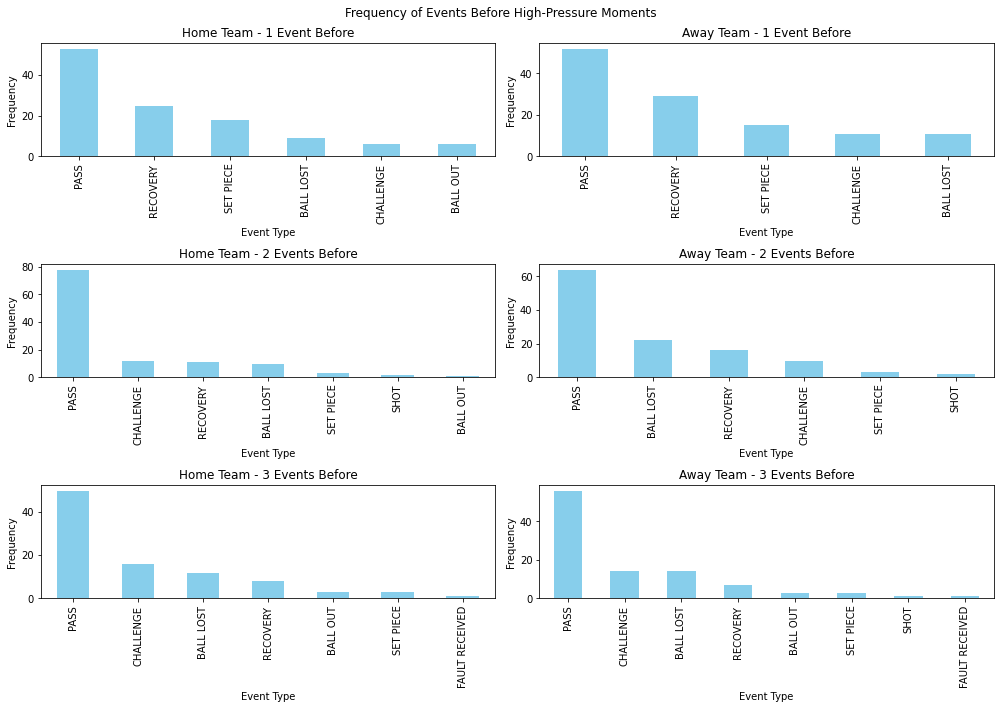

In [85]:
# Function to plot frequency bar charts
def plot_event_frequencies(freq_data, title, ax):
    freq_data.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Event Type')

# Creating subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10), tight_layout=True)
fig.suptitle('Frequency of Events Before High-Pressure Moments')

# Plotting for Home Team
plot_event_frequencies(freq_home_1, 'Home Team - 1 Event Before', axes[0, 0])
plot_event_frequencies(freq_home_2, 'Home Team - 2 Events Before', axes[1, 0])
plot_event_frequencies(freq_home_3, 'Home Team - 3 Events Before', axes[2, 0])

# Plotting for Away Team
plot_event_frequencies(freq_away_1, 'Away Team - 1 Event Before', axes[0, 1])
plot_event_frequencies(freq_away_2, 'Away Team - 2 Events Before', axes[1, 1])
plot_event_frequencies(freq_away_3, 'Away Team - 3 Events Before', axes[2, 1])

plt.show()

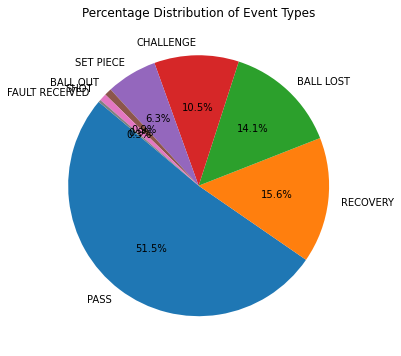

In [86]:
# Pie Chart for percentage distribution of event types
event_type_counts = leading_events_away['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Save Event Triples for both Teams

In [89]:
triples_home.to_csv("triples_home")
triples_away.to_csv("triples_away")

In [91]:
leading_events_away
leading_events_home

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,23.32,31.28,39.22,25.16,1.0,55.96
1,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,-1.06,21.76,12.72,21.76,1.0,55.96
2,Away,PASS,NaN,1,1170,46.80,1224,48.96,Player20,Player18,-14.84,-10.20,-14.84,17.68,1.0,55.96
3,Home,RECOVERY,INTERCEPTION,1,1431,57.24,1431,57.24,Player1,NaN,39.22,25.16,NaN,NaN,1.0,57.24
4,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,23.32,31.28,39.22,25.16,1.0,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,Away,PASS,NaN,2,135929,5437.16,135985,5439.40,Player21,Player23,-21.20,-18.36,-39.22,-25.84,2.0,5437.80
323,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,2,135910,5436.40,135910,5436.40,Player21,NaN,-21.20,-17.00,NaN,NaN,2.0,5437.80
324,Away,PASS,NaN,2,135876,5435.04,135894,5435.76,Player19,Player21,-18.02,-25.16,-22.26,-17.00,2.0,5437.80
325,Home,RECOVERY,NaN,2,136961,5478.44,136961,5478.44,Player11,NaN,-46.64,-6.12,NaN,NaN,2.0,5478.44


In [92]:
leading_events_away.drop(['Start Frame', 'End Frame', 'Start Time [s]', 'End Time [s]', 'Period', 'Start X', 'Start Y', 'End X', 'End Y'], axis=1, inplace=True)
leading_events_away

,Team,Type,Subtype,From,To,Moment Period,Moment Time [s]
0,Away,PASS,NaN,Player16,Player17,1.0,31.68
1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68
2,Away,PASS,NaN,Player15,Player16,1.0,31.68
3,Away,PASS,NaN,Player15,Player16,1.0,38.72
4,Away,PASS,NaN,Player16,Player15,1.0,38.72
...,...,...,...,...,...,...,...
329,Away,PASS,NaN,Player15,Player16,2.0,5375.28
330,Away,PASS,NaN,Player23,Player15,2.0,5375.28
331,Away,PASS,NaN,Player20,Player23,2.0,5375.28
332,Home,SET PIECE,FREE KICK,Player9,NaN,2.0,5595.92


In [95]:
#Save leading events for Teams
leading_events_away.to_csv('leading_events_away.csv')
leading_events_home.to_csv('leading_events_home.csv')

Combining Type and Subtype of events for further analysis

In [121]:
# Creating the 'Type_s' column by combining 'Type' and 'Subtype'
leading_events_away['Type_s'] = leading_events_away.apply(lambda row: f"{row['Type']} - {row['Subtype']}" if pd.notna(row['Subtype']) else row['Type'], axis=1)

# Display the first few rows to confirm the new column
leading_events_away

,Unnamed: 0,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s
0,0,Away,PASS,NaN,Player16,Player17,1.0,31.68,PASS
1,1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68,SET PIECE - THROW IN
2,2,Away,PASS,NaN,Player15,Player16,1.0,31.68,PASS
3,3,Away,PASS,NaN,Player15,Player16,1.0,38.72,PASS
4,4,Away,PASS,NaN,Player16,Player15,1.0,38.72,PASS
...,...,...,...,...,...,...,...,...,...
329,329,Away,PASS,NaN,Player15,Player16,2.0,5375.28,PASS
330,330,Away,PASS,NaN,Player23,Player15,2.0,5375.28,PASS
331,331,Away,PASS,NaN,Player20,Player23,2.0,5375.28,PASS
332,332,Home,SET PIECE,FREE KICK,Player9,NaN,2.0,5595.92,SET PIECE - FREE KICK


Triples dataframe with combined type and subtype

In [122]:
# Grouping the data by 'Moment Time [s]' and creating triples of 'Type_s'
triples_away = leading_events_away.groupby('Moment Time [s]')['Type_s'].apply(lambda x: list(x)[:3])

# Convert the Series to a DataFrame for easier visualization
triples_away_df = pd.DataFrame(triples_away.tolist(), index=triples_away.index, columns=['Event 1', 'Event 2', 'Event 3'])

# Display the first few rows of the triples DataFrame
triples_away_df

,Event 1,Event 2,Event 3
Moment Time [s],,,
31.68,PASS,SET PIECE - THROW IN,PASS
38.72,PASS,PASS,PASS
120.88,BALL LOST - INTERCEPTION,PASS,PASS
153.52,PASS,PASS,PASS
166.40,PASS,PASS,PASS
...,...,...,...
5155.92,PASS,PASS,SET PIECE - FREE KICK
5184.12,PASS,PASS,PASS
5187.76,PASS,PASS,PASS


Leading Events Type and Subtype Visualization For Team Away

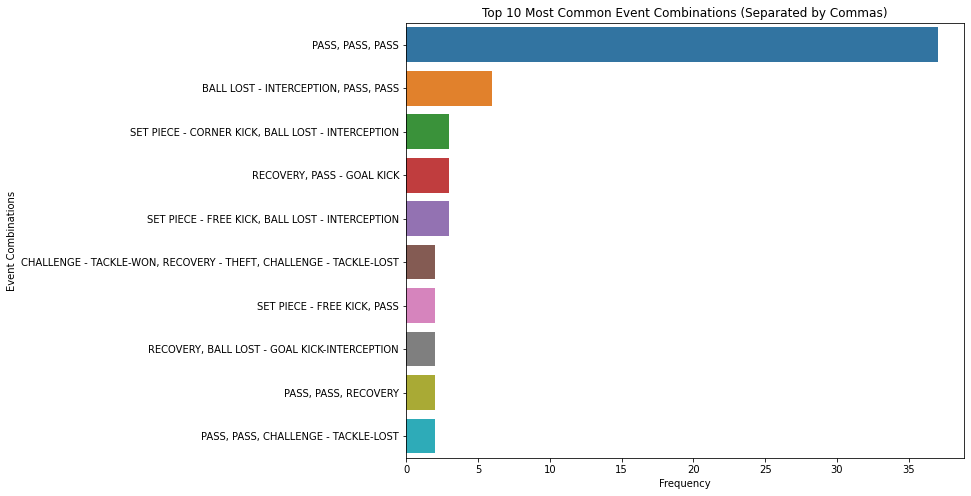

In [98]:
# Function to create pairs or singles from triples with ',' as a separator
def create_combinations(triple):
    # Filter out None values and join with ','
    filtered_events = [event for event in triple if event is not None]
    return ', '.join(filtered_events)

# Applying the function to create pairs or singles from triples with ',' as a separator
type_combinations = triples_away.apply(create_combinations)

# Counting the frequency of each adjusted triple (or pair/single) with ',' as a separator
type_combinations_count = type_combinations.value_counts()

# Creating a bar plot for the most common Leading Events for Away
plt.figure(figsize=(10, 8))
sns.barplot(y=type_combinations_count.index[:10], x=type_combinations_count.values[:10])  # Displaying top 10
plt.title('Top 10 Most Common Event Combinations (Separated by Commas)')
plt.xlabel('Frequency')
plt.ylabel('Event Combinations')
plt.show()

Separate Periods for Heatmap

In [100]:
# Separate the data by period
period_1_data = tracking_data[tracking_data['Period'] == 1]
period_2_data = tracking_data[tracking_data['Period'] == 2]


In [ ]:
period_1_data

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,Away_18_x,Away_18_y,Away_19_x,Away_19_y,Away_20_x,Away_20_y,Away_21_x,Away_21_y,Away_22_x,Away_22_y,Away_23_x,Away_23_y,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
0,1,0.04,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.09860,-0.51198,9.36088,0.0,0.0,46.93150,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.08,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.09860,-0.51198,9.36088,0.0,0.0,46.93150,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.12,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.09860,-0.51198,9.36088,0.0,0.0,46.93150,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.16,-51.70892,-1.19884,-18.19384,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.09860,-0.51198,9.36088,0.0,0.0,46.93150,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.35076,16.40840,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.20,-51.70892,-1.19884,-18.25002,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.09860,-0.51198,9.36088,0.0,0.0,46.93150,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.43980,16.40772,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67936,1,2717.48,-52.89930,-3.85016,-10.48976,-28.22204,-17.49636,-19.77916,-18.04120,-8.12056,-16.57098,0.78268,-5.65934,-31.29768,-10.38058,-21.20716,-7.36700,-8.95016,-17.23984,4.75252,2.79522,-29.77584,-3.88172,-7.78192,0.0,0.0,33.43876,-15.61144,1.41722,-14.74444,2.45708,-19.69688,4.98412,-24.61260,1.31652,-18.41372,-5.40600,-22.64060,-0.90418,-16.53556,-4.33222,-33.12144,-10.53004,-0.61540,-15.82262,-6.78640,-17.27800,-19.87096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67937,1,2717.52,-52.92050,-3.85628,-10.48976,-28.22204,-17.43488,-19.81044,-18.00834,-8.16748,-16.54342,0.76296,-5.64662,-31.35072,-10.36574,-21.27244,-7.35428,-9.00796,-17.24938,4.71580,2.78356,-29.83772,-3.87430,-7.83904,0.0,0.0,33.34866,-15.68352,1.41934,-14.82468,2.45072,-19.74380,4.97352,-24.66428,1.31652,-18.41372,-5.39116,-22.68548,-0.90736,-16.57296,-4.31632,-33.17788,-10.49930,-0.67524,-15.78870,-6.81768,-17.24938,-19.89884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67938,1,2717.56,-52.93322,-3.85628,-10.48976,-28.22204,-17.35114,-19.84

In [102]:
# Home team in period 1
home_columns = [col for col in period_1_data.columns if 'Home' in col]
home_positions = period_1_data[home_columns]

# Reshape the data to have all x and y positions in two columns
home_x = home_positions.filter(like='_x').values.flatten()
home_y = home_positions.filter(like='_y').values.flatten()

# Remove NaN values if any
home_x = home_x[~np.isnan(home_x)]
home_y = home_y[~np.isnan(home_y)]


c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


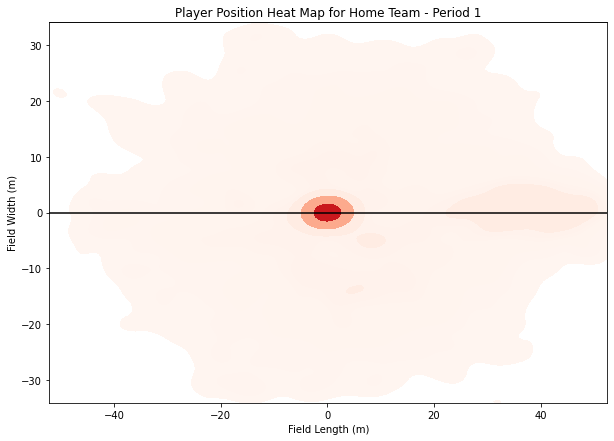

In [ ]:
# Define the dimensions of a soccer field
field_dimen = (105, 68)  # in meters, standard soccer field dimensions

# Create a figure
plt.figure(figsize=(10, 7))

# Create a heat map
sns.kdeplot(home_x, home_y, cmap="Reds", shade=True, shade_lowest=False)

# Set the limits to the size of the field
plt.xlim(-52.2, 52.5)
plt.ylim(-34, 34)

# Add field markings (optional)
plt.axhline(y=field_dimen[1]/2, color='black', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=field_dimen[1], color='black', linestyle='-')

# Add title and labels
plt.title('Player Position Heat Map for Home Team - Period 1')
plt.xlabel('Field Length (m)')
plt.ylabel('Field Width (m)')

# Show the plot
plt.show()


In [116]:
leading_events_away = pd.read_csv('leading_events_away.csv')
home_event = pd.read_csv('home_event.csv')

In [118]:
leading_events_away

,Unnamed: 0,Team,Type,Subtype,From,To,Moment Period,Moment Time [s]
0,0,Away,PASS,NaN,Player16,Player17,1.0,31.68
1,1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68
2,2,Away,PASS,NaN,Player15,Player16,1.0,31.68
3,3,Away,PASS,NaN,Player15,Player16,1.0,38.72
4,4,Away,PASS,NaN,Player16,Player15,1.0,38.72
...,...,...,...,...,...,...,...,...
329,329,Away,PASS,NaN,Player15,Player16,2.0,5375.28
330,330,Away,PASS,NaN,Player23,Player15,2.0,5375.28
331,331,Away,PASS,NaN,Player20,Player23,2.0,5375.28
332,332,Home,SET PIECE,FREE KICK,Player9,NaN,2.0,5595.92


In [123]:
# encoding the 'Type_s' column
le_type_s = LabelEncoder()
leading_events_away['Type_s_encoded'] = le_type_s.fit_transform(leading_events_away['Type_s'])

# Re-encoding the 'From' and 'To' columns, handling NaN values
le_player = LabelEncoder()
all_players = pd.concat([leading_events_away['From'], leading_events_away['To']]).dropna().unique()
le_player.fit(all_players)
leading_events_away['From_encoded'] = le_player.transform(leading_events_away['From'])
leading_events_away['To_encoded'] = leading_events_away['To'].map(lambda x: le_player.transform([x])[0] if pd.notna(x) else np.nan)

# Preparing the final dataset for clustering
cluster_data_away = leading_events_away[['Type_s_encoded', 'From_encoded', 'To_encoded']].fillna(-1)

# Re-performing clustering
kmeans_away = KMeans(n_clusters=5, random_state=0).fit(cluster_data_away)

# Adding the cluster labels to the original dataframe
leading_events_away['Cluster'] = kmeans_away.labels_

# Attempting to display the first few rows again
leading_events_away.head()

,Unnamed: 0,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s,Type_s_encoded,From_encoded,To_encoded,Cluster
0,0,Away,PASS,NaN,Player16,Player17,1.0,31.68,PASS,19,8,9.0,0
1,1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68,SET PIECE - THROW IN,30,7,NaN,0
2,2,Away,PASS,NaN,Player15,Player16,1.0,31.68,PASS,19,7,8.0,0
3,3,Away,PASS,NaN,Player15,Player16,1.0,38.72,PASS,19,7,8.0,0
4,4,Away,PASS,NaN,Player16,Player15,1.0,38.72,PASS,19,8,7.0,0


In [124]:
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = leading_events_away[leading_events_away['Cluster'] == cluster_num]

    # Most common event types in this cluster
    common_types = ', '.join(cluster_data['Type_s'].value_counts().head(3).index)
    
    # Most common 'From' players in this cluster
    common_from_players = ', '.join(cluster_data['From'].value_counts().head(3).index)
    
    # Most common 'To' players in this cluster
    common_to_players = ', '.join(cluster_data['To'].value_counts().head(3).index)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Create DataFrame with the cluster analysis
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)

# Save the DataFrame to a CSV file
cluster_analysis_df.to_csv('cluster_analysis_output_away.csv')
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,"PASS, RECOVERY - INTERCEPTION, RECOVERY","Player16, Player15, Player10","Player16, Player17, Player15"
1,PASS,"Player5, Player6, Player4","Player8, Player9, Player5"
2,"PASS, RECOVERY, RECOVERY - INTERCEPTION","Player25, Player5, Player9","Player1, Player10, Player12"
3,"BALL LOST - INTERCEPTION, BALL LOST, BALL LOST...","Player5, Player9, Player4",
4,"PASS, PASS - GOAL KICK","Player10, Player2, Player1","Player8, Player9, Player5"


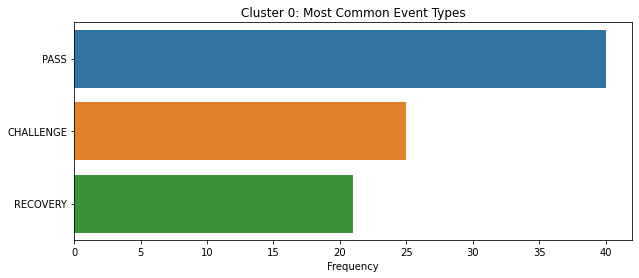

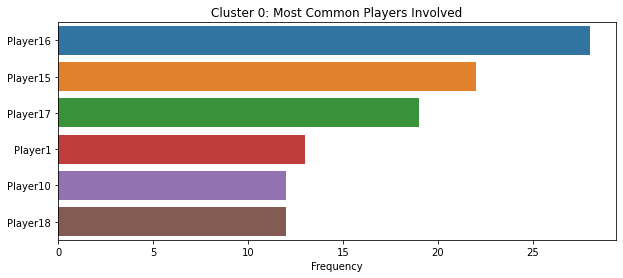

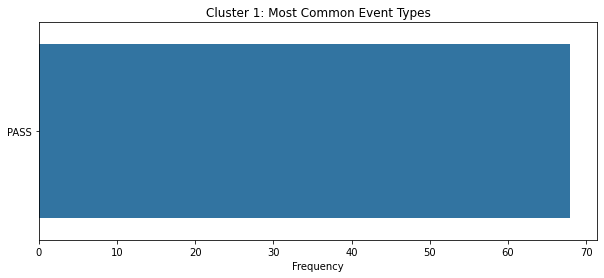

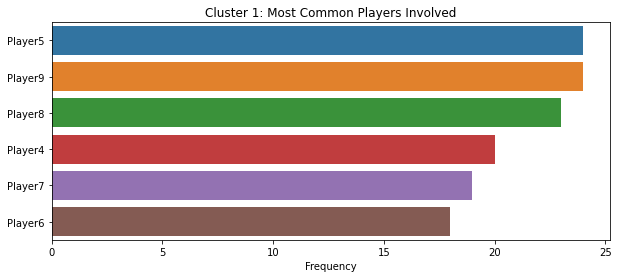

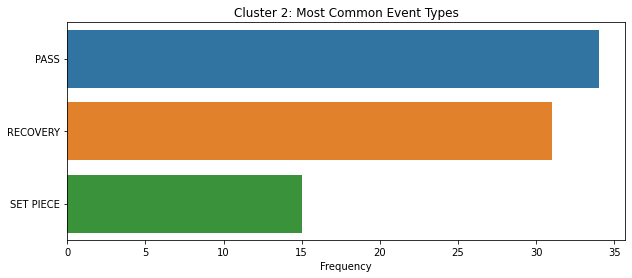

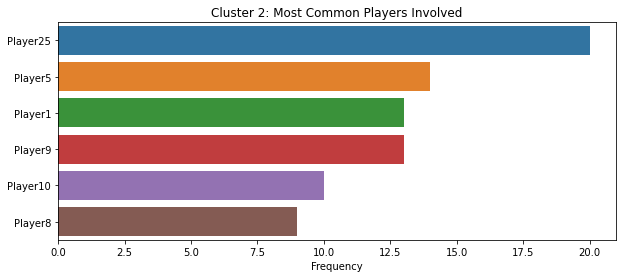

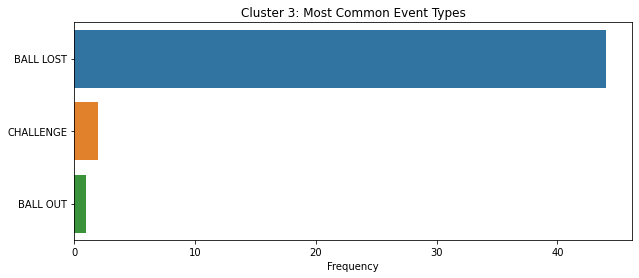

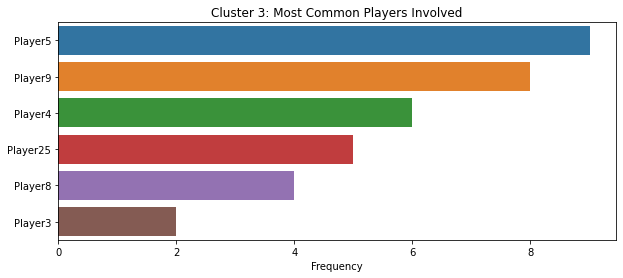

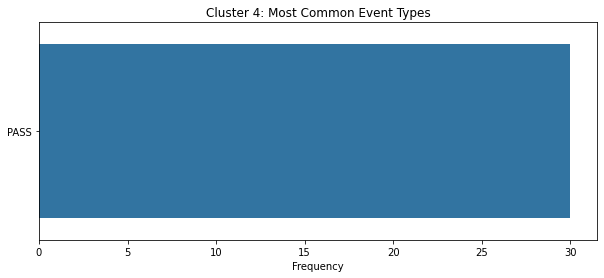

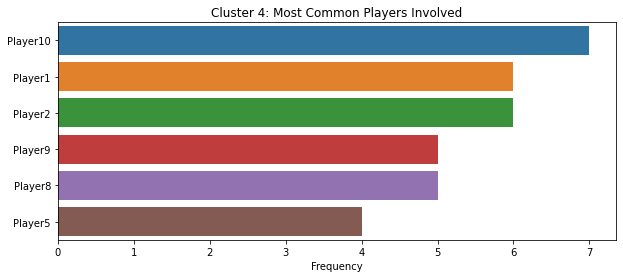

In [126]:
def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = leading_events_away[leading_events_away['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [127]:
leading_events_home.drop(['Start Frame', 'End Frame', 'Start Time [s]', 'End Time [s]', 'Period', 'Start X', 'Start Y', 'End X', 'End Y'], axis=1, inplace=True)
leading_events_home

leading_events_home.to_csv('leading_events_home.csv')

# Creating the 'Type_s' column by combining 'Type' and 'Subtype'
leading_events_home['Type_s'] = leading_events_home.apply(lambda row: f"{row['Type']} - {row['Subtype']}" if pd.notna(row['Subtype']) else row['Type'], axis=1)

# Display the first few rows to confirm the new column
leading_events_home

,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s
0,Away,BALL LOST,INTERCEPTION,Player24,NaN,1.0,55.96,BALL LOST - INTERCEPTION
1,Away,PASS,NaN,Player18,Player24,1.0,55.96,PASS
2,Away,PASS,NaN,Player20,Player18,1.0,55.96,PASS
3,Home,RECOVERY,INTERCEPTION,Player1,NaN,1.0,57.24,RECOVERY - INTERCEPTION
4,Away,BALL LOST,INTERCEPTION,Player24,NaN,1.0,57.24,BALL LOST - INTERCEPTION
...,...,...,...,...,...,...,...,...
322,Away,PASS,NaN,Player21,Player23,2.0,5437.80,PASS
323,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,Player21,NaN,2.0,5437.80,CHALLENGE - TACKLE-ADVANTAGE-WON
324,Away,PASS,NaN,Player19,Player21,2.0,5437.80,PASS
325,Home,RECOVERY,NaN,Player11,NaN,2.0,5478.44,RECOVERY


In [128]:
# Grouping the data by 'Moment Time [s]' and creating triples of 'Type_s'
triples_home = leading_events_home.groupby('Moment Time [s]')['Type_s'].apply(lambda x: list(x)[:3])

# Convert the Series to a DataFrame for easier visualization
triples_home_df = pd.DataFrame(triples_home.tolist(), index=triples_home.index, columns=['Event 1', 'Event 2', 'Event 3'])

# Display the first few rows of the triples DataFrame
triples_home_df

,Event 1,Event 2,Event 3
Moment Time [s],,,
55.96,BALL LOST - INTERCEPTION,PASS,PASS
57.24,RECOVERY - INTERCEPTION,BALL LOST - INTERCEPTION,PASS
101.80,PASS,PASS,RECOVERY - INTERCEPTION
131.48,PASS,RECOVERY,BALL LOST
569.48,PASS,PASS,PASS
...,...,...,...
5387.04,PASS,PASS,PASS
5397.68,BALL LOST - INTERCEPTION,RECOVERY,RECOVERY - INTERCEPTION
5417.24,PASS,PASS,PASS


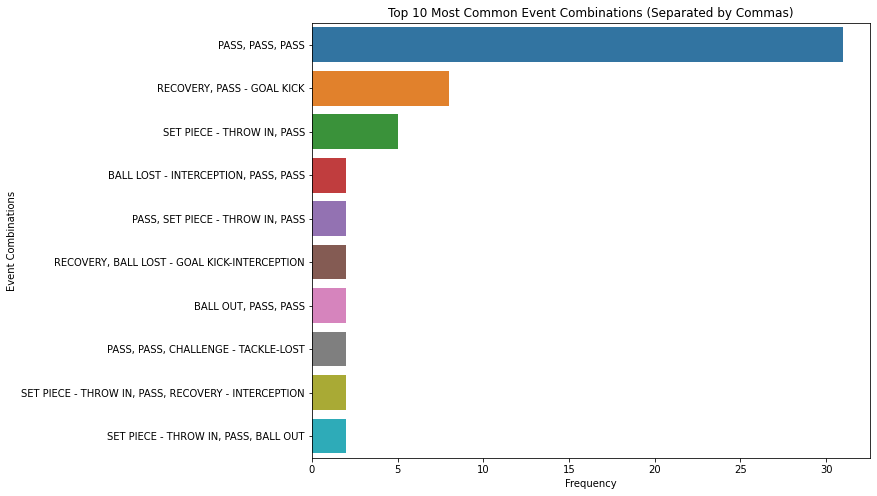

In [129]:
# Function to create pairs or singles from triples with ',' as a separator
def create_combinations(triple):
    # Filter out None values and join with ','
    filtered_events = [event for event in triple if event is not None]
    return ', '.join(filtered_events)

# Applying the function to create pairs or singles from triples with ',' as a separator
type_combinations = triples_home.apply(create_combinations)

# Counting the frequency of each adjusted triple (or pair/single) with ',' as a separator
type_combinations_count = type_combinations.value_counts()

# Creating a bar plot for the most common Leading Events for Home
plt.figure(figsize=(10, 8))
sns.barplot(y=type_combinations_count.index[:10], x=type_combinations_count.values[:10])  # Displaying top 10
plt.title('Top 10 Most Common Event Combinations (Separated by Commas)')
plt.xlabel('Frequency')
plt.ylabel('Event Combinations')
plt.show()

In [130]:
def create_event_triples(triple_leading_events):
    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        events = group.to_dict('records')
        triple = [events[i] if i < len(events) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['Event 1', 'Event 2', 'Event 3'])

triples_away = create_event_triples(leading_events_away)

triples_away.head()


,Event 1,Event 2,Event 3
0,"{'Unnamed: 0': 0, 'Team': 'Away', 'Type': 'PAS...","{'Unnamed: 0': 1, 'Team': 'Away', 'Type': 'SET...","{'Unnamed: 0': 2, 'Team': 'Away', 'Type': 'PAS..."
1,"{'Unnamed: 0': 3, 'Team': 'Away', 'Type': 'PAS...","{'Unnamed: 0': 4, 'Team': 'Away', 'Type': 'PAS...","{'Unnamed: 0': 5, 'Team': 'Away', 'Type': 'PAS..."
2,"{'Unnamed: 0': 6, 'Team': 'Home', 'Type': 'BAL...","{'Unnamed: 0': 7, 'Team': 'Home', 'Type': 'PAS...","{'Unnamed: 0': 8, 'Team': 'Home', 'Type': 'PAS..."
3,"{'Unnamed: 0': 9, 'Team': 'Home', 'Type': 'PAS...","{'Unnamed: 0': 10, 'Team': 'Home', 'Type': 'PA...","{'Unnamed: 0': 11, 'Team': 'Home', 'Type': 'PA..."
4,"{'Unnamed: 0': 12, 'Team': 'Home', 'Type': 'PA...","{'Unnamed: 0': 13, 'Team': 'Home', 'Type': 'PA...","{'Unnamed: 0': 14, 'Team': 'Home', 'Type': 'PA..."


In [131]:
triples_away.to_csv('triples_away.csv')

Visualize the frequency of types of all three leading events for both Teams

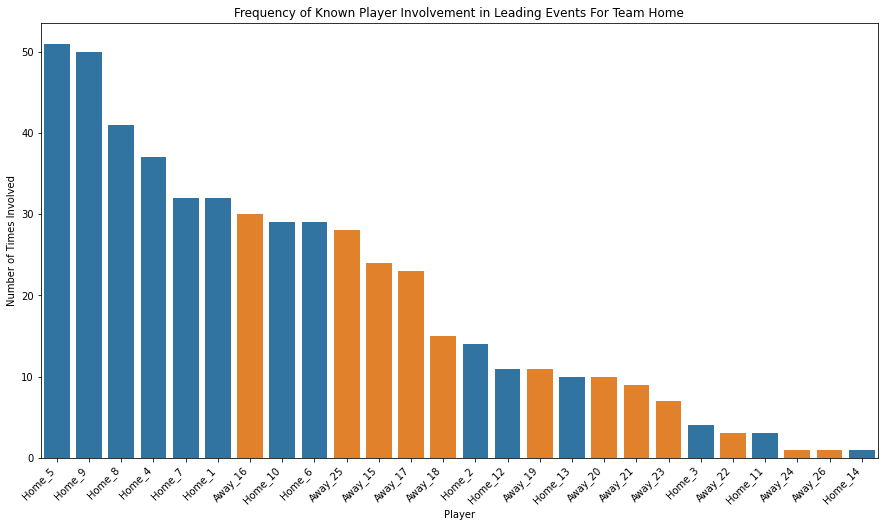

In [133]:
combined_players = leading_events_away['From'].append(leading_events_away['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

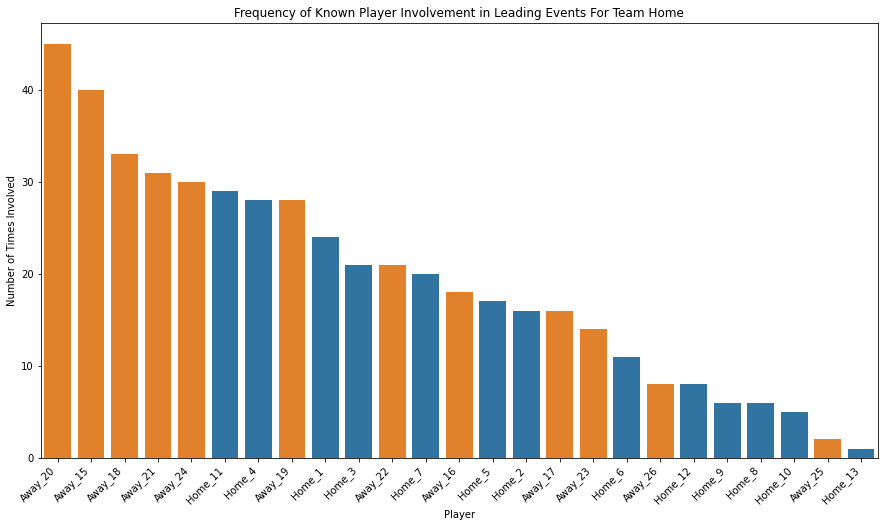

In [ ]:
combined_players = leading_events_home['From'].append(leading_events_home['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

In [137]:
# Save Leading Events
leading_events_home.to_csv("leading_events_home.csv")
leading_events_away.to_csv("leading_events_away.csv")

Grid the Pitch

In [139]:
away_moments_down = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] <= -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] <= -11.33))]
away_moments_down.columns
away_moments_center = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33))]
away_moments_center.columns
away_moments_up = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] >= 11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] >= 11.33))]
away_moments_up.columns


leading_events_away_down = find_leading_events(away_moments_down, events, time_window)
leading_events_away_down.head()

leading_events_away_center = find_leading_events(away_moments_center, events, time_window)
leading_events_away_center.head()

leading_events_away_up = find_leading_events(away_moments_up, events, time_window)
leading_events_away_up.head()

triples_away_down = create_event_triples(leading_events_away_down)
triples_away_center = create_event_triples(leading_events_away_center)
triples_away_up = create_event_triples(leading_events_away_up)

# Create event type triples for home and away
type_triples_away_down = create_event_type_triples(leading_events_away_down)
type_triples_away_center = create_event_type_triples(leading_events_away_center)
type_triples_away_up = create_event_type_triples(leading_events_away_up)

Checking Dimentions of data frames

In [140]:
away_moments_down.shape

(53, 56)

In [141]:
away_moments_center.shape

(39, 56)

In [ ]:
away_moments_up.shape

(26, 56)

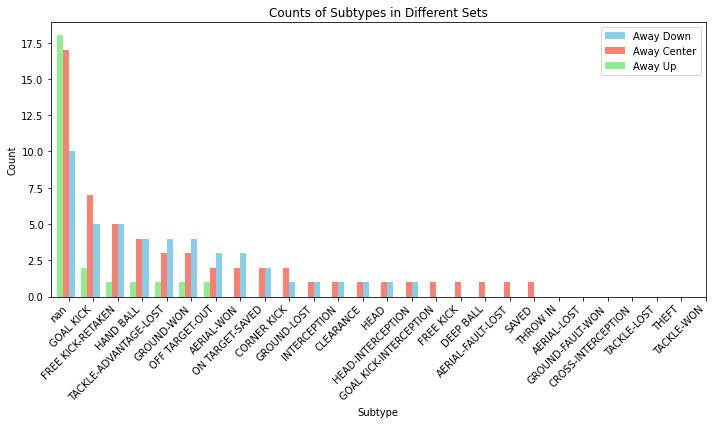

In [142]:
# Combine all subtypes from the three DataFrames to get unique subtypes
all_subtypes = set(leading_events_away_down['Subtype'].unique())
all_subtypes.update(leading_events_away_center['Subtype'].unique())
all_subtypes.update(leading_events_away_up['Subtype'].unique())

# Create a larger figure
plt.figure(figsize=(10, 6))

# Plotting each set of data and setting different colors
leading_events_away_down['Subtype'].value_counts().plot(kind='bar', color='skyblue', position=0, width=0.25, label='Away Down')
leading_events_away_center['Subtype'].value_counts().plot(kind='bar', color='salmon', position=1, width=0.25, label='Away Center')
leading_events_away_up['Subtype'].value_counts().plot(kind='bar', color='lightgreen', position=2, width=0.25, label='Away Up')

# Set labels and title
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.title('Counts of Subtypes in Different Sets')

# Set x-axis ticks and labels at specific positions
plt.xticks(range(len(all_subtypes)), all_subtypes, rotation=45, ha='right')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


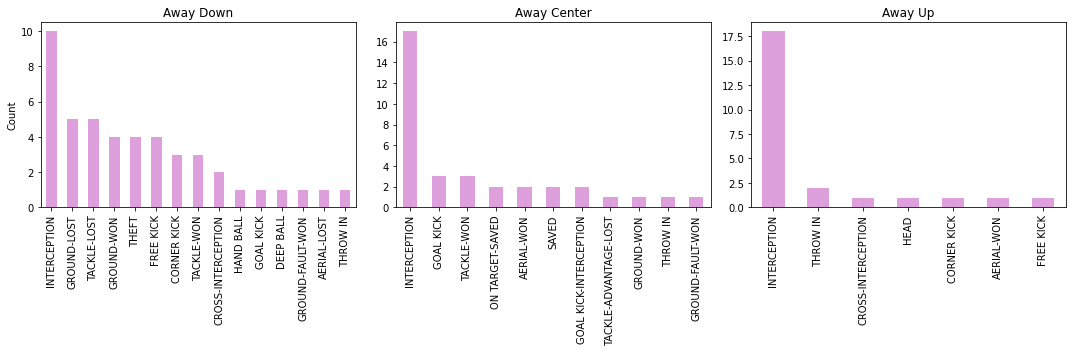

In [143]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting on the first subplot
leading_events_away_down['Subtype'].value_counts().plot(kind='bar', ax=axes[0], color='plum')
axes[0].set_title('Away Down')
axes[0].set_ylabel('Count')

# Plotting on the second subplot
conditions = (leading_events_away_center['Subtype'] != 'FREE KICK') & \
              (leading_events_away_center['Subtype'] != 'TACKLE-LOST') & \
              (leading_events_away_center['Subtype'] != 'THEFT') & \
              (leading_events_away_center['Subtype'] != 'GROUND-LOST') & \
              (leading_events_away_center['Subtype'] != 'OFF TARGET-OUT') & \
              (leading_events_away_center['Subtype'] != 'FREE KICK-RETAKEN') & \
              (leading_events_away_center['Subtype'] != 'AERIAL-FAULT-LOST') & \
              (leading_events_away_center['Subtype'] != 'HEAD-INTERCEPTION') &\
              (leading_events_away_center['Subtype'] != 'CLEARANCE') &\
              (leading_events_away_center['Subtype'] != 'ARIAL-ADVANTAGE-LOST')

leading_events_away_center_trun = leading_events_away_center[conditions]
leading_events_away_center_trun['Subtype'].value_counts().plot(kind='bar', ax=axes[1], color='plum')
axes[1].set_title('Away Center')
axes[1].set_ylabel('') 

# Plotting on the third subplot
leading_events_away_up['Subtype'].value_counts().plot(kind='bar', ax=axes[2], color='plum')
axes[2].set_title('Away Up')
axes[2].set_ylabel('') 

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


<AxesSubplot:>

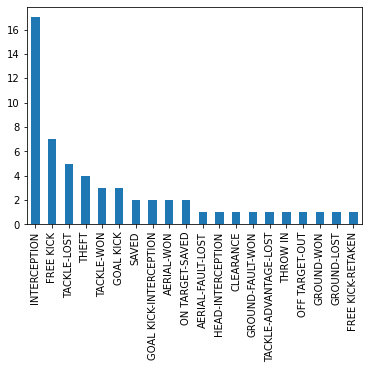

In [144]:
leading_events_away_center['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

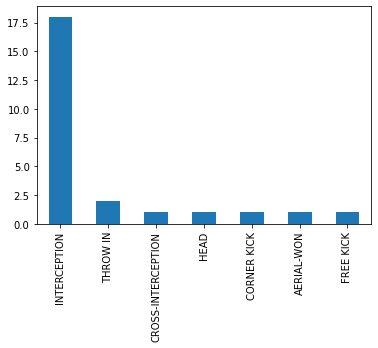

In [145]:
leading_events_away_up['Subtype'].value_counts().plot(kind='bar')

Same griding for team Home

<AxesSubplot:>

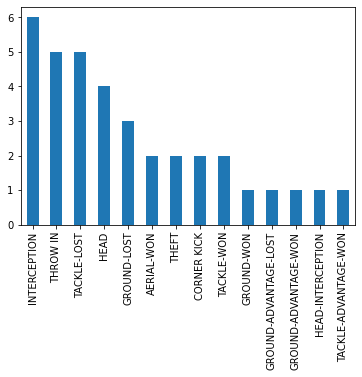

In [148]:
home_moments_down = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] <= -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] <= -11.33))]
home_moments_center = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33))]
home_moments_up = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] >= 11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] >= 11.33))]

leading_events_home_down = find_leading_events(home_moments_down, events, time_window)
leading_events_home_down.head()

leading_events_home_center = find_leading_events(home_moments_center, events, time_window)
leading_events_home_center.head()

leading_events_home_up = find_leading_events(home_moments_up, events, time_window)
leading_events_home_up.head()

triples_home_down = create_event_triples(leading_events_home_down)
triples_home_center = create_event_triples(leading_events_home_center)
triples_home_up = create_event_triples(leading_events_home_up)

# Create event type triples for home and home
type_triples_home_down = create_event_type_triples(leading_events_home_down)
type_triples_home_center = create_event_type_triples(leading_events_home_center)
type_triples_home_up = create_event_type_triples(leading_events_home_up)

leading_events_home_down['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

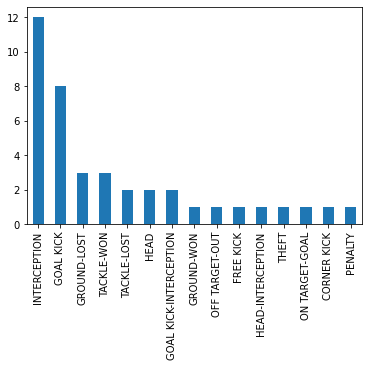

In [147]:
leading_events_home_center['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

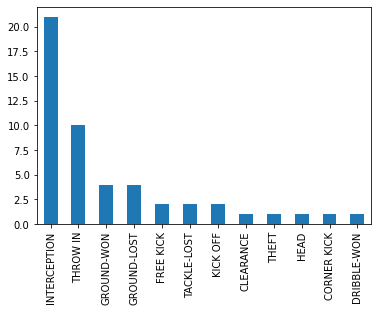

In [ ]:
leading_events_home_up['Subtype'].value_counts().plot(kind='bar')

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


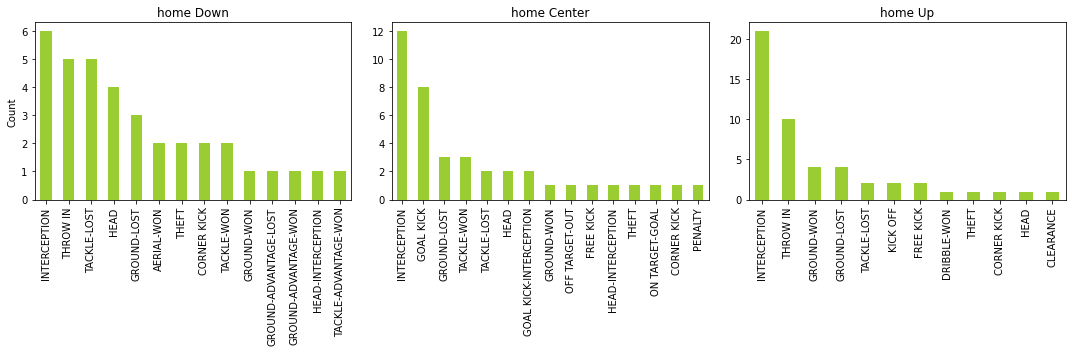

In [149]:
# Create a figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting on the first subplot


leading_events_home_down['Subtype'].value_counts().plot(kind='bar', ax=axes[0], color='yellowgreen')
axes[0].set_title('home Down')
axes[0].set_ylabel('Count')


leading_events_home_center['Subtype'].value_counts().plot(kind='bar', ax=axes[1], color='yellowgreen')
axes[1].set_title('home Center')
axes[1].set_ylabel('') 

# Plotting on the third subplot
leading_events_home_up['Subtype'].value_counts().plot(kind='bar', ax=axes[2], color='yellowgreen')
axes[2].set_title('home Up')
axes[2].set_ylabel('') 

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
leading_events_home_down.shape

(103, 16)

In [ ]:
leading_events_home_up.shape

(138, 16)

In [ ]:
home_moments_up.shape

(48, 56)

In [ ]:
home_moments_center.shape

(36, 56)

In [ ]:
home_moments_down.shape

(36, 56)

In [ ]:
leading_events_home_center.shape

(95, 16)

In [ ]:
leading_events_away_up.shape

In [ ]:
leading_events_away_center.shape

(103, 16)

In [ ]:
leading_events_away_down.shape

(155, 16)

In [ ]:
type_triples_away_up.columns

Index(['1 Event Before', '2 Events Before', '3 Events Before'], dtype='object')

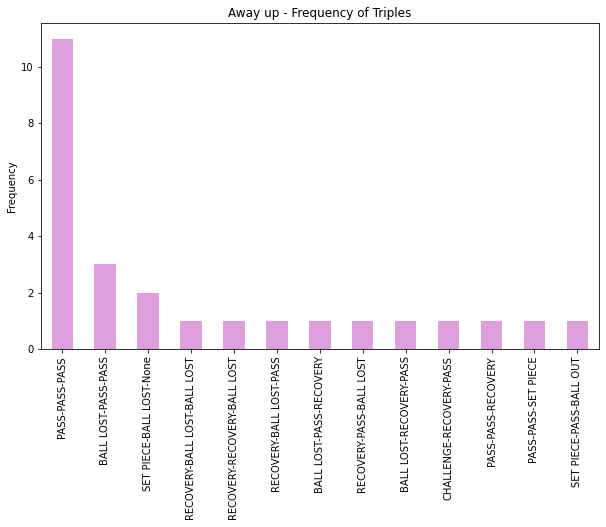

In [150]:
type_triples_away_up['Concatenated'] = type_triples_away_up.apply(lambda x: f"{x['1 Event Before']}-{x['2 Events Before']}-{x['3 Events Before']}", axis=1)

# Plot the frequency of triples
plt.figure(figsize=(10, 6))
type_triples_away_up['Concatenated'].value_counts().plot(kind='bar', color='plum')
plt.title('Away up - Frequency of Triples')
plt.ylabel('Frequency')
plt.show()

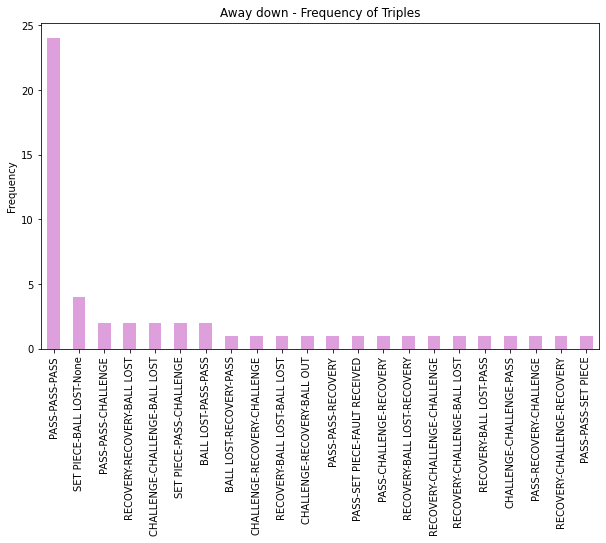

In [151]:
type_triples_away_down['Concatenated'] = type_triples_away_down.apply(lambda x: f"{x['1 Event Before']}-{x['2 Events Before']}-{x['3 Events Before']}", axis=1)

# Plot the frequency of triples
plt.figure(figsize=(10, 6))
type_triples_away_down['Concatenated'].value_counts().plot(kind='bar', color='plum')
plt.title('Away down - Frequency of Triples')
plt.ylabel('Frequency')
plt.show()

##### SEPRATING PERIODS For Team Home to see if there is any specific patterns or relation between periods

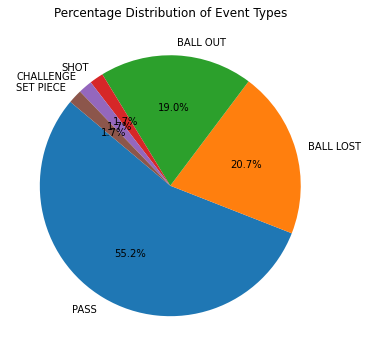

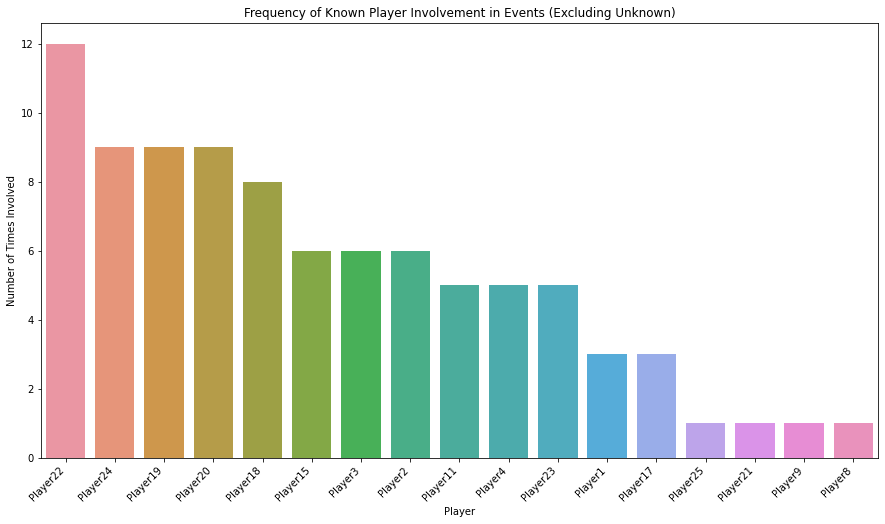

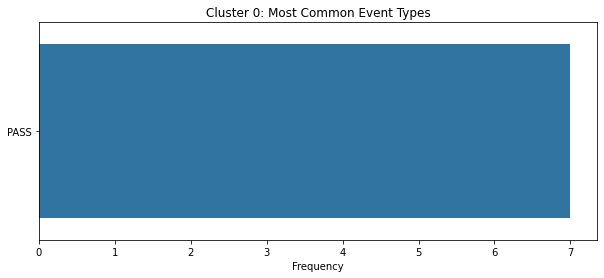

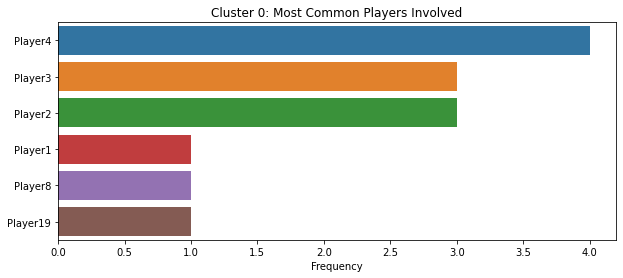

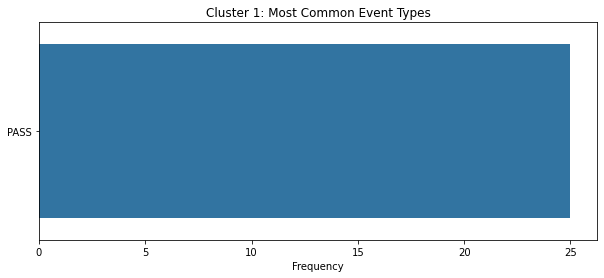

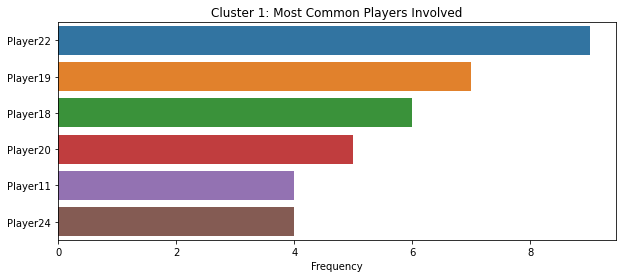

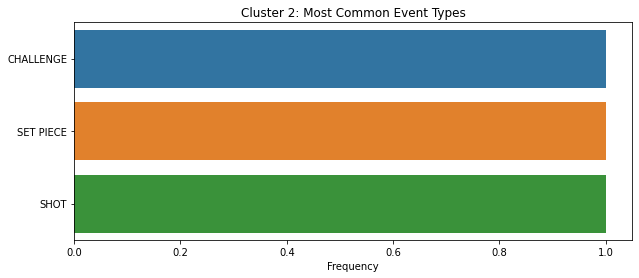

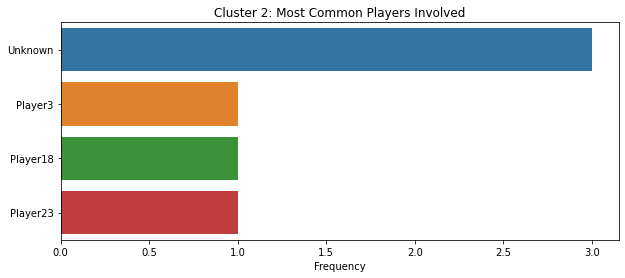

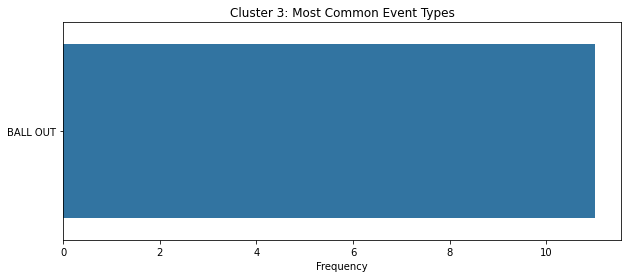

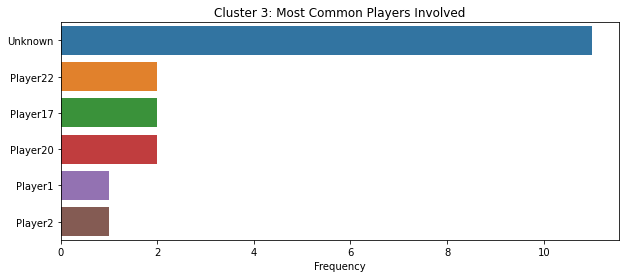

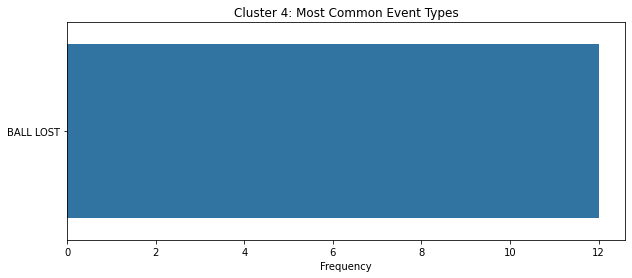

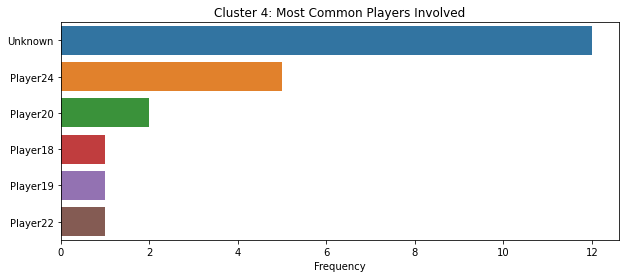

In [ ]:

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1))]

home_moments.columns


import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Period 2

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


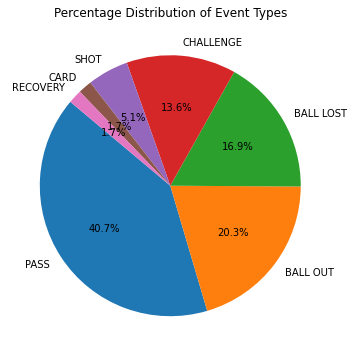

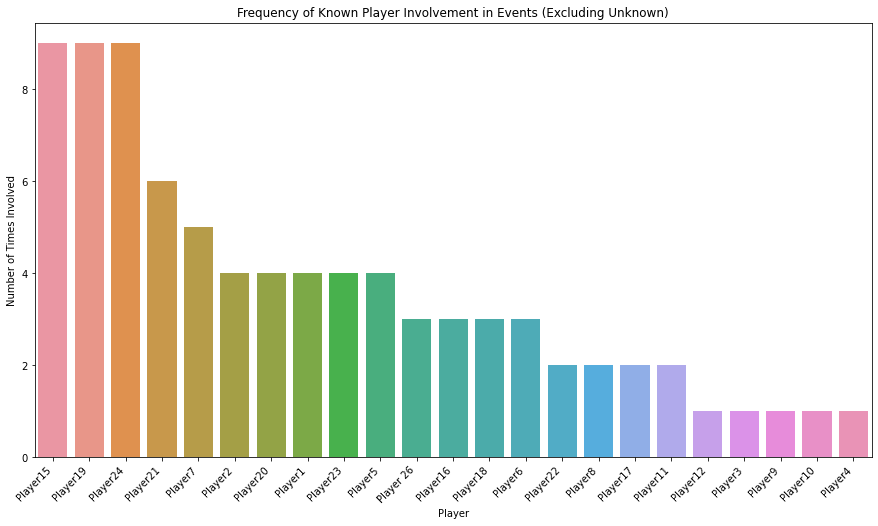

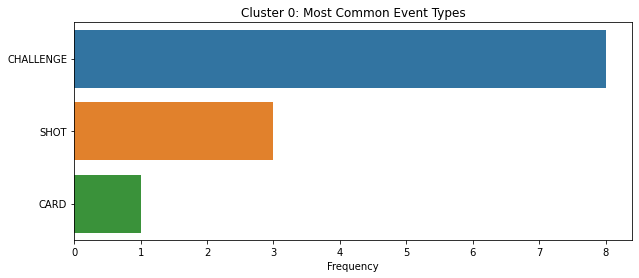

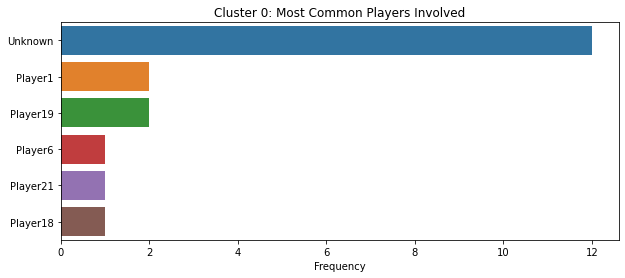

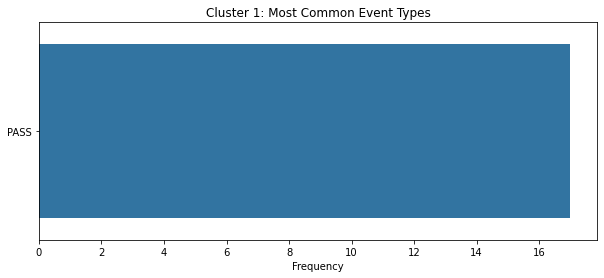

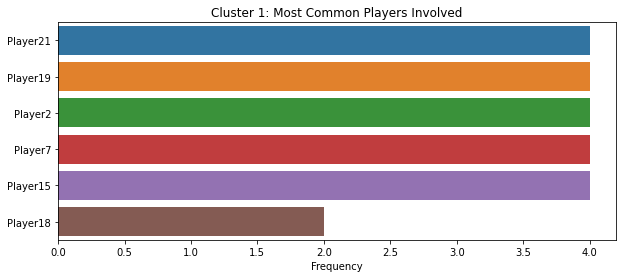

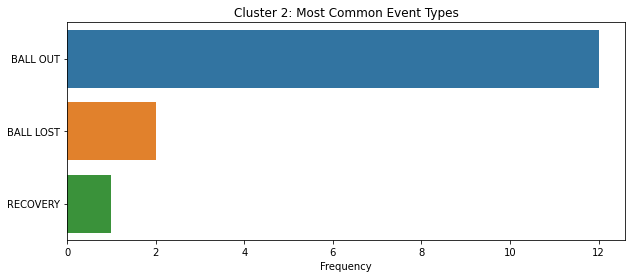

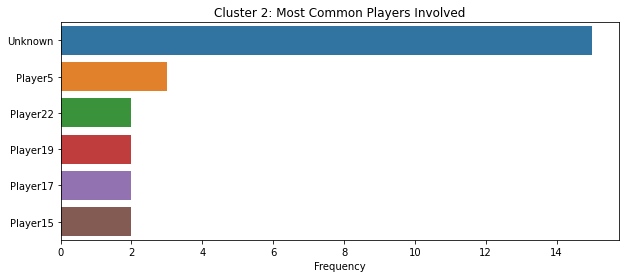

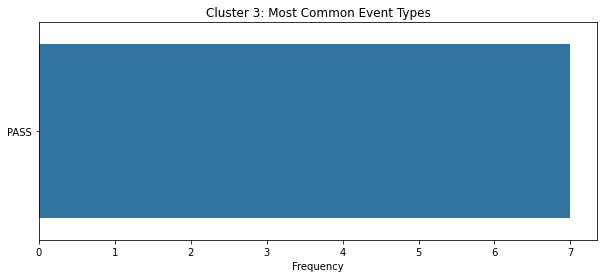

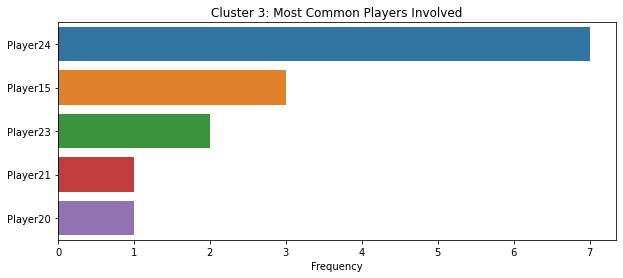

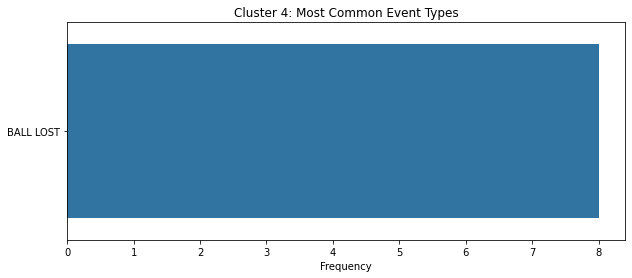

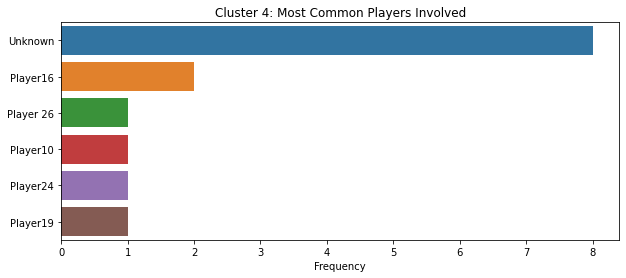

In [ ]:

home_moments = tracking_data[(tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2)]
home_moments.columns

a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [ ]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [ ]:
events['Subtype'].unique()

array(['KICK OFF', nan, 'INTERCEPTION', 'GROUND-LOST', 'GROUND-WON',
       'THROW IN', 'AERIAL-WON', 'HEAD-INTERCEPTION', 'AERIAL-LOST',
       'HEAD', 'OFF TARGET-OUT', 'TACKLE-LOST', 'AERIAL-FAULT-WON',
       'AERIAL-FAULT-LOST', 'FREE KICK', 'TACKLE-WON', 'CORNER KICK',
       'THEFT', 'CROSS', 'ON TARGET-GOAL', 'ON TARGET-SAVED', 'SAVED',
       'BLOCKED', 'DEEP BALL', 'GROUND-FAULT-LOST', 'GROUND-FAULT-WON',
       'GROUND-ADVANTAGE-LOST', 'GROUND-ADVANTAGE-WON',
       'HEAD-OFF TARGET-OUT', 'GOAL KICK-INTERCEPTION',
       'TACKLE-FAULT-LOST', 'OFFSIDE', 'TACKLE-FAULT-WON', 'YELLOW',
       'CLEARANCE', 'GOAL KICK', 'TACKLE-ADVANTAGE-WON',
       'CROSS-INTERCEPTION', 'GROUND', 'FORCED', 'FAULT-WON',
       'OFF TARGET-HEAD-OUT', 'FORCED-END HALF', 'KICK OFF-RETAKEN',
       'HEAD-ON TARGET-GOAL', 'HEAD-INTERCEPTION-CLEARANCE',
       'TACKLE-ADVANTAGE-LOST', 'HEAD-CLEARANCE', 'FREE KICK-RETAKEN',
       'HAND BALL', 'PENALTY', 'DRIBBLE-WON', 'CLEARANCE-INTERCEPTION'],
      d

In [ ]:
events['Type'].unique()


array(['SET PIECE', 'PASS', 'BALL LOST', 'CHALLENGE', 'RECOVERY',
       'BALL OUT', 'SHOT', 'FAULT RECEIVED', 'CARD'], dtype=object)